In [ ]:
"""
3. Tareas Desglosadas:
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
Etapa 2: Análisis Exploratorio

Crear gráficos y tablas para visualizar:

Frecuencia de campeones, roles y objetos.
Relación entre KDA (Kills/Deaths/Assists) y victorias.
Eficiencia en objetivos (torretas, dragones, etc.) y resultados de partidas.
Realizar segmentaciones:

Por roles (jungla, mid, etc.).
Por regiones si los datos están disponibles.
Etapa 3: Análisis Avanzado

Series de tiempo:

Analizar cambios en la popularidad de campeones/estrategias a lo largo del parche.
Análisis de correlación:

Evaluar qué métricas tienen mayor correlación con la victoria.
Outliers:

Detectar jugadores, campeones o equipos con métricas anómalas (ejemplo: daño altísimo o tasas de victoria extremas).
Análisis de Cohortes:

Crear cohortes basadas en tiempo jugado, composición de equipo, o estrategias comunes.
Etapa 4: Modelado Predictivo

Clasificación:

Crear un modelo para predecir si un equipo ganará o no basado en:
Selección de campeones.
Composición de roles.
Estadísticas acumuladas.
Regresión:

Modelar el impacto de factores como "oro ganado por minuto" en la probabilidad de victoria.
Cumplimiento de Requisitos Mínimos
Scraping: La API de Riot proporcionará datos base.
EDA: Gráficos como histogramas, boxplots y diagramas de dispersión ayudarán a cumplir este punto.
Análisis de calidad: Puedes identificar datos faltantes o duplicados en las partidas.
Segmentación: Dividir datos por roles, regiones o niveles de habilidad.
Modelos predictivos: Usar clasificación y regresión regularizada (ej. Ridge o Lasso).
Análisis de tiempo: Detectar cambios en las tendencias del meta a lo largo del parche.
Correlaciones: Examinar qué métricas afectan más a la victoria.
Cohortes: Segmentar por estrategias o jugadores destacados.
Gráficos: Visualizar variables como daño, roles o victorias.
Outliers: Detectar partidas con resultados extremos para análisis adicional.
Viabilidad en Dos Semanas
Con tres horas al día, este proyecto es ambicioso, pero factible si te organizas bien. Sugiero:

Días 1-4: Obtención de datos y limpieza.
Días 5-7: Análisis exploratorio y gráfico.
Días 8-10: Modelos predictivos y validación.
Días 11-12: Análisis avanzado (cohortes, correlaciones, etc.).
Días 13-14: Refinamiento, documentación, y presentación en GitHub.
Si necesitas más ideas concretas o guía en alguna etapa, dime y profundizamos. ¡Adelante con el proyecto!
"""

In [ ]:
"""
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
"""

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import time
import seaborn as sns


In [2]:

API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"

In [ ]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'euw1'  # Cambia según la región deseada (e.g., na1, kr, etc.)
CHALLENGER_URL = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'
SUMMONER_URL = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_challenger_players():
    """
    Obtiene la lista de jugadores en Challenger junto con sus summonerIds.
    """
    response = requests.get(CHALLENGER_URL, headers=HEADERS)
    if response.status_code == 200:
        challenger_data = response.json()
        return challenger_data['entries']  # Lista de LeagueItemDTO
    else:
        print(f"Error al obtener la lista de Challengers: {response.status_code}")
        return []

def get_puuid(summoner_id):
    """
    Obtiene el PUUID de un jugador a partir de su summonerId.
    """
    response = requests.get(SUMMONER_URL + summoner_id, headers=HEADERS)
    if response.status_code == 200:
        summoner_data = response.json()
        return summoner_data['puuid']
    else:
        print(f"Error al obtener PUUID para el summonerId {summoner_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def main():
    """
    Obtiene la lista completa de PUUIDs para jugadores Challenger.
    """
    # Obtener jugadores Challenger
    challengers = get_challenger_players()
    print(f"Se encontraron {len(challengers)} jugadores en Challenger.")

    # Extraer PUUIDs
    puuids = []
    requests_count = 0
    start_time = time.time()

    for player in challengers:
        summoner_id = player['summonerId']

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener el PUUID
        puuid = get_puuid(summoner_id)
        requests_count += 1  # Incrementar contador de solicitudes
        if puuid:
            puuids.append(puuid)

    print(f"Se obtuvieron {len(puuids)} PUUIDs.")
    return puuids

if __name__ == "__main__":
    puuids = main()


In [ ]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'europe'  # Para datos de partidas usa la región de clúster, no "euw1"
MATCH_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_DETAILS_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_matches(puuid, start=0, count=20):
    """
    Obtiene una lista de IDs de partidas para un jugador dado su PUUID.
    """
    url = f"{MATCH_URL}{puuid}/ids?start={start}&count={count}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Lista de IDs de partidas
    else:
        print(f"Error al obtener partidas para el PUUID {puuid}: {response.status_code}")
        return []

def get_match_details(match_id):
    """
    Obtiene los detalles de una partida dado su ID.
    """
    url = f"{MATCH_DETAILS_URL}{match_id}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Detalles de la partida
    else:
        print(f"Error al obtener detalles para la partida {match_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def extract_match_data(puuids, matches_per_player=20):
    """
    Extrae datos de partidas para una lista de PUUIDs.
    """
    all_match_details = []
    requests_count = 0
    start_time = time.time()

    for puuid in puuids:
        print(f"Obteniendo partidas para PUUID: {puuid}")

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener IDs de partidas
        match_ids = get_matches(puuid, count=matches_per_player)
        requests_count += 1

        for match_id in match_ids:
            # Control de límite de tasa
            requests_count, start_time = rate_limited_request(requests_count, start_time)

            # Obtener detalles de la partida
            match_details = get_match_details(match_id)
            requests_count += 1

            if match_details:
                all_match_details.append(match_details)

    print(f"Se extrajeron datos de {len(all_match_details)} partidas.")
    return all_match_details

if __name__ == "__main__":
    # Lista de PUUIDs (puedes cargar esta lista desde tu script anterior)
    matches_per_player = 20  # Número de partidas a extraer por jugador

    match_data = extract_match_data(puuids, matches_per_player=matches_per_player)


In [3]:
import pandas as pd

def save_full_match_data_to_csv(match_data, filename="full_match_data.csv"):
    """
    Guarda todos los datos de las partidas en un archivo CSV.
    
    :param match_data: Lista de detalles completos de las partidas.
    :param filename: Nombre del archivo CSV de salida.
    """
    # Lista para almacenar los datos a guardar
    match_rows = []
    
    for match in match_data:
        # Extraer metadatos de la partida
        match_id = match.get("metadata", {}).get("matchId", "")
        data_version = match.get("metadata", {}).get("dataVersion", "")
        participants = match.get("metadata", {}).get("participants", [])
        
        # Extraer info de la partida
        game_creation = match.get("info", {}).get("gameCreation", "")
        game_duration = match.get("info", {}).get("gameDuration", "")
        game_end_timestamp = match.get("info", {}).get("gameEndTimestamp", "")
        game_start_timestamp = match.get("info", {}).get("gameStartTimestamp", "")
        game_mode = match.get("info", {}).get("gameMode", "")
        game_name = match.get("info", {}).get("gameName", "")
        game_type = match.get("info", {}).get("gameType", "")
        game_version = match.get("info", {}).get("gameVersion", "")
        map_id = match.get("info", {}).get("mapId", "")
        platform_id = match.get("info", {}).get("platformId", "")
        queue_id = match.get("info", {}).get("queueId", "")
        tournament_code = match.get("info", {}).get("tournamentCode", "")
        
        # Extraer equipos
        teams = match.get("info", {}).get("teams", [])
        
        # Iterar sobre cada participante en la partida
        for participant in match.get("info", {}).get("participants", []):
            # Extraer los datos del participante
            match_rows.append({
                "match_id": match_id,
                "data_version": data_version,
                "participants": participants,
                "game_creation": game_creation,
                "game_duration": game_duration,
                "game_end_timestamp": game_end_timestamp,
                "game_start_timestamp": game_start_timestamp,
                "game_mode": game_mode,
                "game_name": game_name,
                "game_type": game_type,
                "game_version": game_version,
                "map_id": map_id,
                "platform_id": platform_id,
                "queue_id": queue_id,
                "tournament_code": tournament_code,
                "team_id": participant.get("teamId", ""),
                "summoner_name": participant.get("summonerName", ""),
                "champion_name": participant.get("championName", ""),
                "champion_id": participant.get("championId", ""),
                "kills": participant.get("kills", 0),
                "deaths": participant.get("deaths", 0),
                "assists": participant.get("assists", 0),
                "total_damage_dealt": participant.get("totalDamageDealt", 0),
                "gold_earned": participant.get("goldEarned", 0),
                "win": participant.get("win", False),
                "lane": participant.get("lane", ""),
                "role": participant.get("role", ""),
                "vision_score": participant.get("visionScore", 0),
                "wards_placed": participant.get("wardsPlaced", 0),
                "wards_killed": participant.get("wardsKilled", 0),
                "total_heals_on_teammates": participant.get("totalHealsOnTeammates", 0),
                "total_minions_killed": participant.get("totalMinionsKilled", 0),
                "total_damage_taken": participant.get("totalDamageTaken", 0),
                "time_played": participant.get("timePlayed", 0),
                "total_ally_jungle_minions_killed": participant.get("totalAllyJungleMinionsKilled", 0),
                "total_damage_dealt_to_champions": participant.get("totalDamageDealtToChampions", 0),
                "total_heal": participant.get("totalHeal", 0),
                "total_damage_shielded_on_teammates": participant.get("totalDamageShieldedOnTeammates", 0),
                "total_enemy_jungle_minions_killed": participant.get("totalEnemyJungleMinionsKilled", 0),
                "time_ccing_others": participant.get("timeCCingOthers", 0),
                "total_units_healed": participant.get("totalUnitsHealed", 0),
                "total_kills": participant.get("kills", 0),
                "penta_kills": participant.get("pentaKills", 0),
                "quadra_kills": participant.get("quadraKills", 0),
                "triple_kills": participant.get("tripleKills", 0),
                "double_kills": participant.get("doubleKills", 0),
                "first_blood_kill": participant.get("firstBloodKill", False),
                "first_blood_assist": participant.get("firstBloodAssist", False),
                "first_tower_kill": participant.get("firstTowerKill", False),
                "first_tower_assist": participant.get("firstTowerAssist", False),
                "dragon_kills": participant.get("dragonKills", 0),
                "baron_kills": participant.get("baronKills", 0),
                "inhibitor_kills": participant.get("inhibitorKills", 0),
                "turret_kills": participant.get("turretKills", 0),
                "towers_lost": participant.get("turretsLost", 0),
                "nexus_kills": participant.get("nexusKills", 0),
                "nexus_takedowns": participant.get("nexusTakedowns", 0),
                "total_vision_cleared_pings": participant.get("visionClearedPings", 0),
                "summoner_id": participant.get("summonerId", ""),
                "summoner_level": participant.get("summonerLevel", 0),
                "summoner_name": participant.get("summonerName", ""),
                "profile_icon": participant.get("profileIcon", 0),
                "champ_experience": participant.get("champExperience", 0),
                "champ_level": participant.get("champLevel", 0),
                "role": participant.get("role", ""),
                "individual_position": participant.get("individualPosition", ""),
                "team_position": participant.get("teamPosition", ""),
                "player_augment_1": participant.get("playerAugment1", 0),
                "player_augment_2": participant.get("playerAugment2", 0),
                "player_augment_3": participant.get("playerAugment3", 0),
                "player_augment_4": participant.get("playerAugment4", 0),
                "mission": participant.get("missions", {}),
                "perks": participant.get("perks", {}),
                "total_damage_to_buildings": participant.get("damageDealtToBuildings", 0),
                "total_damage_to_objectives": participant.get("damageDealtToObjectives", 0),
                "damage_self_mitigated": participant.get("damageSelfMitigated", 0),
                "enemy_missing_pings": participant.get("enemyMissingPings", 0),
                "enemy_vision_pings": participant.get("enemyVisionPings", 0),
                "gold_spent": participant.get("goldSpent", 0),
                "hold_pings": participant.get("holdPings", 0),
                "get_back_pings": participant.get("getBackPings", 0),
                "total_units_healed": participant.get("totalUnitsHealed", 0),
                "longest_time_spent_living": participant.get("longestTimeSpentLiving", 0),
                "magic_damage_dealt": participant.get("magicDamageDealt", 0),
                "magic_damage_dealt_to_champions": participant.get("magicDamageDealtToChampions", 0),
                "magic_damage_taken": participant.get("magicDamageTaken", 0),
                "physical_damage_dealt": participant.get("physicalDamageDealt", 0),
                "physical_damage_dealt_to_champions": participant.get("physicalDamageDealtToChampions", 0),
                "physical_damage_taken": participant.get("physicalDamageTaken", 0),
                "true_damage_dealt": participant.get("trueDamageDealt", 0),
                "true_damage_dealt_to_champions": participant.get("trueDamageDealtToChampions", 0),
                "true_damage_taken": participant.get("trueDamageTaken", 0),
                "time_spent_dead": participant.get("totalTimeSpentDead", 0),
                "total_time_cc_dealt": participant.get("totalTimeCCDealt", 0),
                "vision_wards_bought_in_game": participant.get("visionWardsBoughtInGame", 0),
            })
    
    # Crear un DataFrame con los datos
    df = pd.DataFrame(match_rows)
    
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(filename, index=False)
    print(f"Datos guardados en el archivo {filename}")


In [ ]:
# Llamar a la función de guardado
save_full_match_data_to_csv(match_data, filename="full_match_data.csv")


In [ ]:
df.info()

In [ ]:
# Mostrar la distribución de 'game_version'
distribution = df['game_version'].value_counts()

# Mostrar la distribución
print(distribution)


# LEER CSV

In [171]:
import pandas as pd
from io import StringIO

# Cargar el CSV en un DataFrame
df_ultimo_parche = pd.read_csv("merged_dataset_14.23.csv", low_memory=False)

# Ver las primeras filas del DataFrame filtrado
print(df_ultimo_parche.head())


          match_id  data_version  \
0  EUW1_7218125253             2   
1  EUW1_7218125253             2   
2  EUW1_7218125253             2   
3  EUW1_7218125253             2   
4  EUW1_7218125253             2   

                                        participants  game_creation  \
0  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
1  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
2  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
3  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   
4  ['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...  1733567456934   

   game_duration  game_end_timestamp  game_start_timestamp game_mode  \
0           1270       1733568798383         1733567527616      ARAM   
1           1270       1733568798383         1733567527616      ARAM   
2           1270       1733568798383         1733567527616      ARAM   
3           1270       1733568798383         1733567527616      ARAM

In [ ]:
## Juntar dtaframes y eliminar gold_spend



In [ ]:
df_ultimo_parche.shape

In [ ]:
df_ultimo_parche.info()

1. Definir los objetivos específicos
Antes de comenzar con el análisis, asegúrate de tener claros los objetivos que quieres lograr. Como el análisis debe guiar al coach del equipo en la estrategia, algunas áreas clave que podrían ser relevantes son:

Meta actual del juego:

*¿Qué campeones están ganando más partidas? ¿Qué campeones están en las mejores posiciones de win rate en las partidas clasificatorias?

*Posicionamiento de campeones: ¿Cuáles son los campeones más fuertes en cada rol (Top, Jungle, Mid, ADC, Support)?

*Tendencias de objetos: ¿Qué objetos están siendo más efectivos para ciertos campeones o roles?

*Impacto de los dragones, torres, y objetivos mayores: ¿Qué impacto tienen en el resultado final de las partidas las tomas de dragón, torres y barones?

*Composición de equipos: ¿Qué combinaciones de campeones son más exitosas en determinadas composiciones de equipo?


Análisis exploratorio de los datos (EDA)
El análisis exploratorio es clave para entender las características de las partidas y establecer patrones. Algunos análisis que puedes hacer son:

Distribución de los roles y campeones: Analiza qué campeones y roles predominan en las partidas de alto nivel. Esto podría ayudarte a identificar los "pick" más comunes en el meta actual.

Estudio de las estadísticas individuales de los jugadores:

KDA (Killer/Death/Assist): Este es un buen indicador para medir el rendimiento de los jugadores en las partidas.
Gold Earned y Items Comprados: Ver cómo los diferentes objetos se correlacionan con el desempeño del jugador.

In [ ]:
# Ver las primeras filas del DataFrame filtrado
df_ultimo_parche.info()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de los campeones
champion_counts = df_ultimo_parche['champion_name'].value_counts()

# Graficar la distribución de campeones
plt.figure(figsize=(31, 10))
sns.barplot(x=champion_counts.index, y=champion_counts.values, palette='viridis')
plt.xticks(rotation=90)  # Para girar los nombres de los campeones si son largos
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Partidas')
plt.title('Distribución de Campeones en el Dataset')
plt.show()


In [ ]:
# Distribución de roles 
role_counts = df_ultimo_parche['team_position'].value_counts()

# Graficar la distribución de roles
plt.figure(figsize=(8, 6))
sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')
plt.xlabel('Rol')
plt.ylabel('Cantidad de Jugadores')
plt.title('Distribución de Roles en el Dataset')
plt.show()


In [ ]:
#Vemos que UTILITY es support
# Cambiar "UTILITY" a "SUPPORT" en la columna 'team_position'
df_ultimo_parche['team_position'] = df_ultimo_parche['team_position'].replace('UTILITY', 'SUPPORT')

# Verificar los cambios
print(df_ultimo_parche['team_position'].value_counts())


In [ ]:
# Agrupar por campeón y rol
champion_role_counts = df_ultimo_parche.groupby(['champion_name', 'team_position']).size().reset_index(name='count')

# Ver las primeras filas
champion_role_counts.head()


In [ ]:
# Pivotar la tabla para que los campeones sean las filas, los roles sean las columnas
champion_role_pivot = champion_role_counts.pivot(index='champion_name', columns='team_position', values='count').fillna(0)

# Graficar la distribución de campeones por rol
plt.figure(figsize=(65, 20))
champion_role_pivot.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 8))
plt.title('Distribución de Campeones y Roles')
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Jugadores')
plt.xticks(rotation=90)
plt.legend(title='Roles')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por rol y campeón, contando las apariciones
role_champion_counts = df.groupby(['team_position', 'champion_name']).size().reset_index(name='count')

# Calcular proporciones por rol
role_champion_counts['proportion'] = role_champion_counts.groupby('team_position')['count'].transform(lambda x: x / x.sum() * 100)

# Roles únicos en el dataset
roles = role_champion_counts['team_position'].unique()

# Crear un gráfico para cada rol
for role in roles:
    plt.figure(figsize=(22, 20))
    data = role_champion_counts[role_champion_counts['team_position'] == role]
    data = data.sort_values('proportion', ascending=False)
    
    sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')
    
    plt.title(f'Distribución de campeones jugados en {role}', fontsize=16)
    plt.xlabel('Porcentaje (%)', fontsize=12)
    plt.ylabel('Campeón', fontsize=12)
    plt.tight_layout()
    plt.show()



KDA
=
Kills
+
Asistencias
/
Muertes

​

In [208]:
# Ejemplo de análisis de KDA
df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')
#df_kda_champs = df_ultimo_parche.groupby('champion_name')['kda'].mean().sort_values(ascending=False)

df_ultimo_parche.head(60)

,match_id,data_version,participants,game_creation,game_duration,game_end_timestamp,game_start_timestamp,game_mode,game_version,team_id,...,time_played,team_position,team_win,team_first_blood,team_first_tower,first_baron,first_dragon,first_inhibitor,team_tower_kills,kda
0,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,100,...,1270,NaN,False,False,False,False,False,True,2,4.0
1,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,100,...,1270,NaN,False,False,False,False,False,True,2,3.833333
2,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,100,...,1270,NaN,False,False,False,False,False,True,2,2.45
3,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,100,...,1270,NaN,False,False,False,False,False,True,2,2.473684
4,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,100,...,1270,NaN,False,False,False,False,False,True,2,2.5
5,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,200,...,1270,NaN,True,False,False,False,False,False,4,6.222222
6,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,200,...,1270,NaN,True,False,False,False,False,False,4,4.727273
7,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,200,...,1270,NaN,True,False,False,False,False,False,4,2.5
8,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,200,...,1270,NaN,True,False,False,False,False,False,4,3.2
9,EUW1_7218125253,2,['_Xq_XM4XjwvWXqYSQf5nqGQ9RBkk9U3Na--1Sep3POa7...,1733567456934,1270,1733568798383,1733567527616,ARAM,14.23.636.9832,200,...,1270,NaN,True,False,False,False,False,False,4,2.473684


### Boxplot de duración de partida según victoria o derrota

In [210]:
df_ultimo_parche['game_duration_minutes'] = df_ultimo_parche['game_duration'] / 60

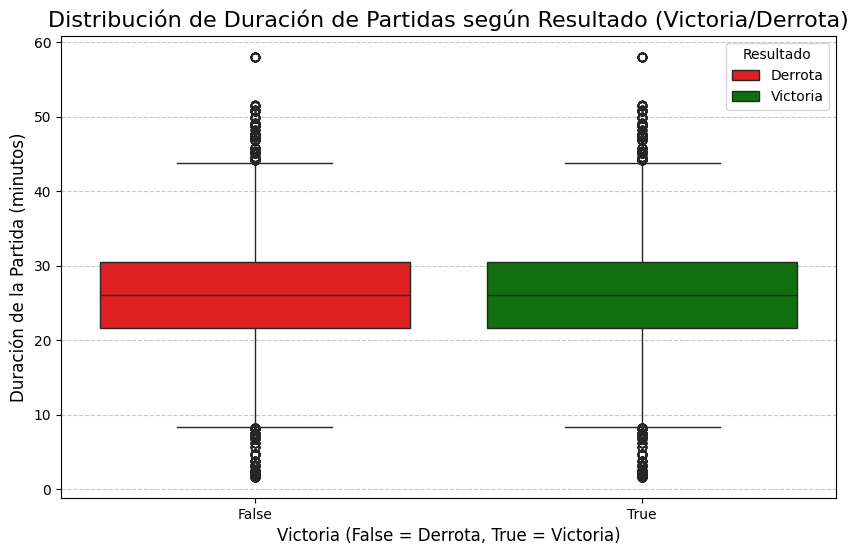

In [211]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ultimo_parche, x='win', y='game_duration_minutes', hue='win', 
            palette={True: "green", False: "red"})
plt.title("Distribución de Duración de Partidas según Resultado (Victoria/Derrota)", fontsize=16)
plt.xlabel("Victoria (False = Derrota, True = Victoria)", fontsize=12)
plt.ylabel("Duración de la Partida (minutos)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Resultado", loc="upper right", labels=["Derrota", "Victoria"])
plt.show()

### Top campeones más seleccionados por día.

<Figure size 1400x800 with 0 Axes>

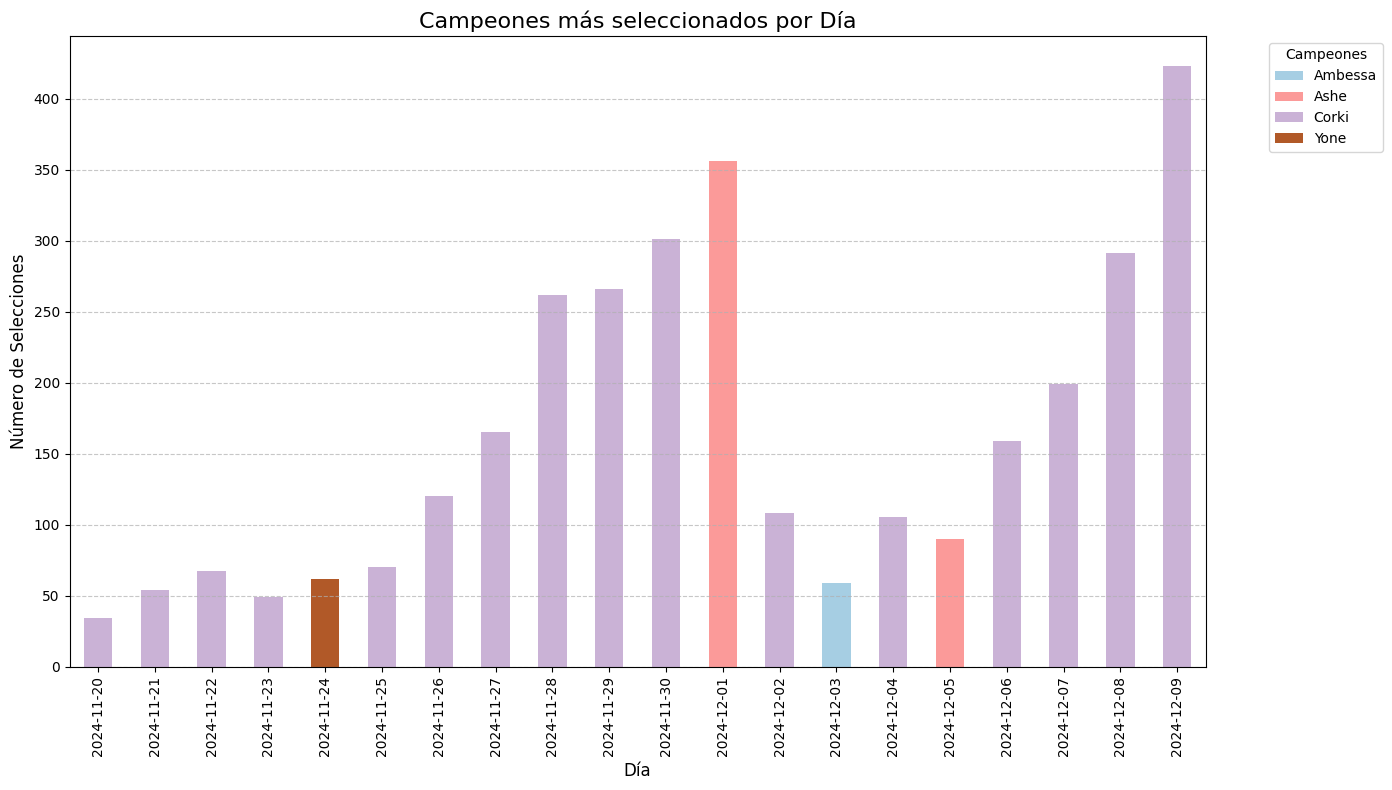

Conteo exacto de campeones por día (Top 10):
champion_name         day  Ambessa   Ashe  Corki  Yone
0              2024-11-20      0.0    0.0   34.0   0.0
1              2024-11-21      0.0    0.0   54.0   0.0
2              2024-11-22      0.0    0.0   67.0   0.0
3              2024-11-23      0.0    0.0   49.0   0.0
4              2024-11-24      0.0    0.0    0.0  62.0
5              2024-11-25      0.0    0.0   70.0   0.0
6              2024-11-26      0.0    0.0  120.0   0.0
7              2024-11-27      0.0    0.0  165.0   0.0
8              2024-11-28      0.0    0.0  262.0   0.0
9              2024-11-29      0.0    0.0  266.0   0.0
10             2024-11-30      0.0    0.0  301.0   0.0
11             2024-12-01      0.0  356.0    0.0   0.0
12             2024-12-02      0.0    0.0  108.0   0.0
13             2024-12-03     59.0    0.0    0.0   0.0
14             2024-12-04      0.0    0.0  105.0   0.0
15             2024-12-05      0.0   90.0    0.0   0.0
16             2024-

In [126]:
df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')

df_ultimo_parche['day'] = df_ultimo_parche['game_start_timestamp'].dt.date


# Filtracion de los datos para excluir el día 2024-12-02
df_ultimo_parche = df_ultimo_parche[df_ultimo_parche['day'] != pd.to_datetime('2024-12-10').date()]

# Calcula los campeones más seleccionados por día
top_champions_daily = (
    df_ultimo_parche.groupby(['champion_name', 'day'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)

# Se selecciona el top 10 campeones por día
top_10_champions_daily = top_champions_daily.groupby('day').head(1) #cambiar el head para ver los TOPS

# Reestructura los datos para un gráfico apilado
pivot_data = top_10_champions_daily.pivot(index='day', columns='champion_name', values='count').fillna(0)

plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='Paired', figsize=(14, 8))

plt.title('Campeones más seleccionados por Día', fontsize=16)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Número de Selecciones', fontsize=12)
plt.legend(title='Campeones', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Datos exactos en una tabla sobre los top 10 campeones seleccionados por día
tabla_top_champions = pivot_data.reset_index()

print("Conteo exacto de campeones por día (Top 10):")
print(tabla_top_champions)
tabla_top_champions.to_csv("top10campeones_diario.csv")




In [127]:

df_ultimo_parche['game_date'] = df_ultimo_parche['game_start_timestamp'].dt.floor('D')

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\2646425197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = df_ultimo_parche['game_start_timestamp'].dt.floor('D')


In [128]:
# Convertir las marcas de tiempo a formato de fecha
fecha_min = pd.to_datetime(df_ultimo_parche['game_end_timestamp'].min(), unit='ms')
fecha_max = pd.to_datetime(df_ultimo_parche['game_end_timestamp'].max(), unit='ms')

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")


Fecha mínima: 2024-11-20 09:25:04.616000
Fecha máxima: 2024-12-10 00:23:01.768000


### Comportamiento de los Jugadores en Días Laborales y Fines de Semana

Número de partidas jugadas en días laborales vs fines de semana.

In [129]:
df_ultimo_parche.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104690 entries, 0 to 113559
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   match_id                         104690 non-null  object        
 1   data_version                     104690 non-null  int64         
 2   participants                     104690 non-null  object        
 3   game_creation                    104690 non-null  int64         
 4   game_duration                    104690 non-null  int64         
 5   game_end_timestamp               104690 non-null  datetime64[ns]
 6   game_start_timestamp             104690 non-null  datetime64[ns]
 7   game_mode                        104690 non-null  object        
 8   game_version                     104690 non-null  object        
 9   team_id                          104690 non-null  int64         
 10  summoner_name                    98181 non-null  

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1866904604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1866904604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1866904604.py:5: SettingWithCopyWarning: 
A value is trying to be s

<Figure size 1200x600 with 0 Axes>

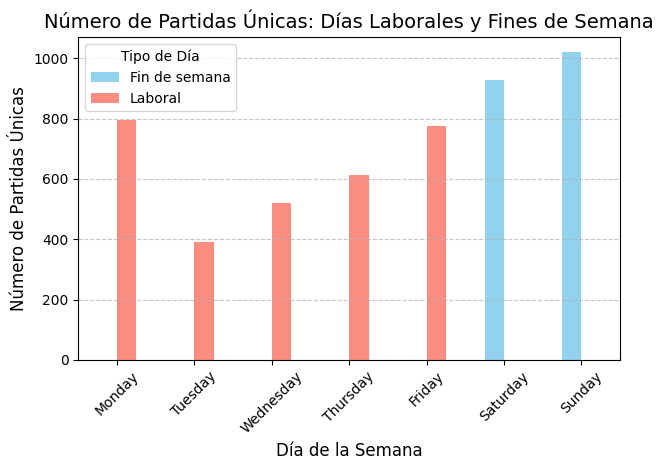

In [131]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_creation'].dt.dayofweek

df_ultimo_parche['day_type'] = df_ultimo_parche['day_of_week'].apply(lambda x: 'Laboral' if x < 5 else 'Fin de semana')

df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)

game_count_by_day_type = (
    df_ultimo_parche.groupby(['day_name', 'day_type'])['match_id']
    .nunique()  
    .unstack() 
)

plt.figure(figsize=(12, 6))
game_count_by_day_type.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], alpha=0.9)
plt.title('Número de Partidas Únicas: Días Laborales y Fines de Semana', fontsize=14)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Número de Partidas Únicas', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Tipo de Día', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()



In [132]:
tabla_game_count = game_count_by_day_type.reset_index()

print("Número partidas jugadas dias laborales y fin de semana:")
print(tabla_game_count)

Número partidas jugadas dias laborales y fin de semana:
day_type   day_name  Fin de semana  Laboral
0            Monday              0      796
1           Tuesday              0      391
2         Wednesday              0      520
3          Thursday              0      613
4            Friday              0      777
5          Saturday            929        0
6            Sunday           1020        0


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\2748800235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\2748800235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date


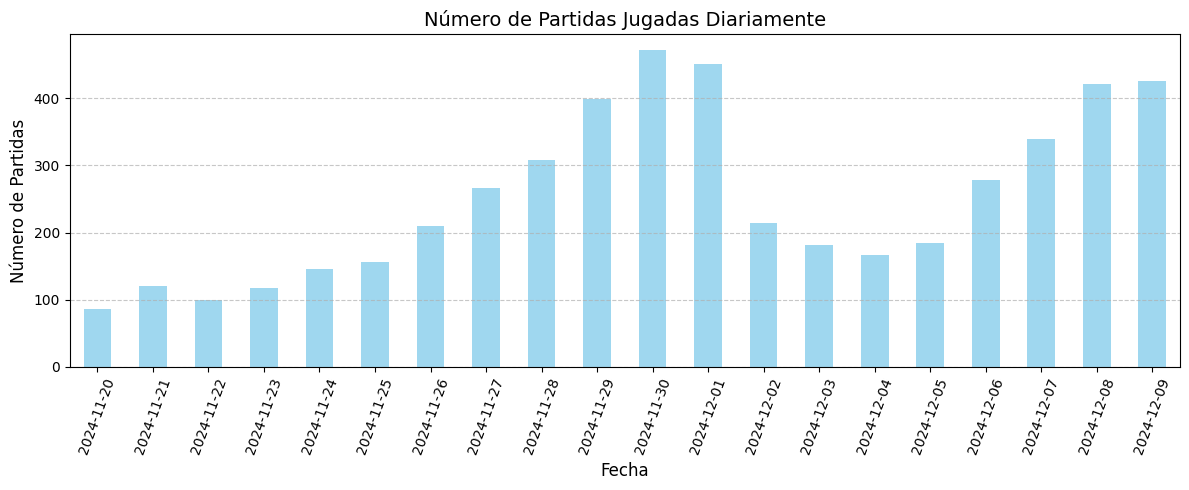

In [133]:
import matplotlib.pyplot as plt

df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date

game_count_by_date = (
    df_ultimo_parche.groupby(['game_date'])['match_id']
    .nunique()  # Asegura que cada partida se cuenta una sola vez
    .rename('game_counter')
)

plt.figure(figsize=(12, 5))
game_count_by_date.plot(kind='bar', color='skyblue', alpha=0.8)

plt.title('Número de Partidas Jugadas Diariamente', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Partidas', fontsize=12)
plt.xticks(rotation=70, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [134]:
tabla_game_count = game_count_by_date.reset_index()

print("Número partidas jugadas por día:")
print(tabla_game_count)


Número partidas jugadas por día:
     game_date  game_counter
0   2024-11-20            86
1   2024-11-21           121
2   2024-11-22           100
3   2024-11-23           117
4   2024-11-24           146
5   2024-11-25           156
6   2024-11-26           210
7   2024-11-27           267
8   2024-11-28           308
9   2024-11-29           399
10  2024-11-30           472
11  2024-12-01           452
12  2024-12-02           214
13  2024-12-03           181
14  2024-12-04           167
15  2024-12-05           184
16  2024-12-06           278
17  2024-12-07           340
18  2024-12-08           422
19  2024-12-09           426


### Distribución de victorias por día de semana y horas

In [135]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Extrae la hora de inicio
df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour



C:\Users\HP\AppData\Local\Temp\ipykernel_10584\2356958752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\2356958752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour


In [136]:
df_ultimo_parche['win'].value_counts()



win
False    52345
True     52345
Name: count, dtype: int64

In [137]:
# Filtro solo partidas ganadas
df_wins = df_ultimo_parche[df_ultimo_parche['win'] == True]

# Cuenta las partidas únicas ganadas por día de la semana y hora
win_counts = (
    df_wins.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # contador de partidas únicas
    .unstack(fill_value=0)  
)

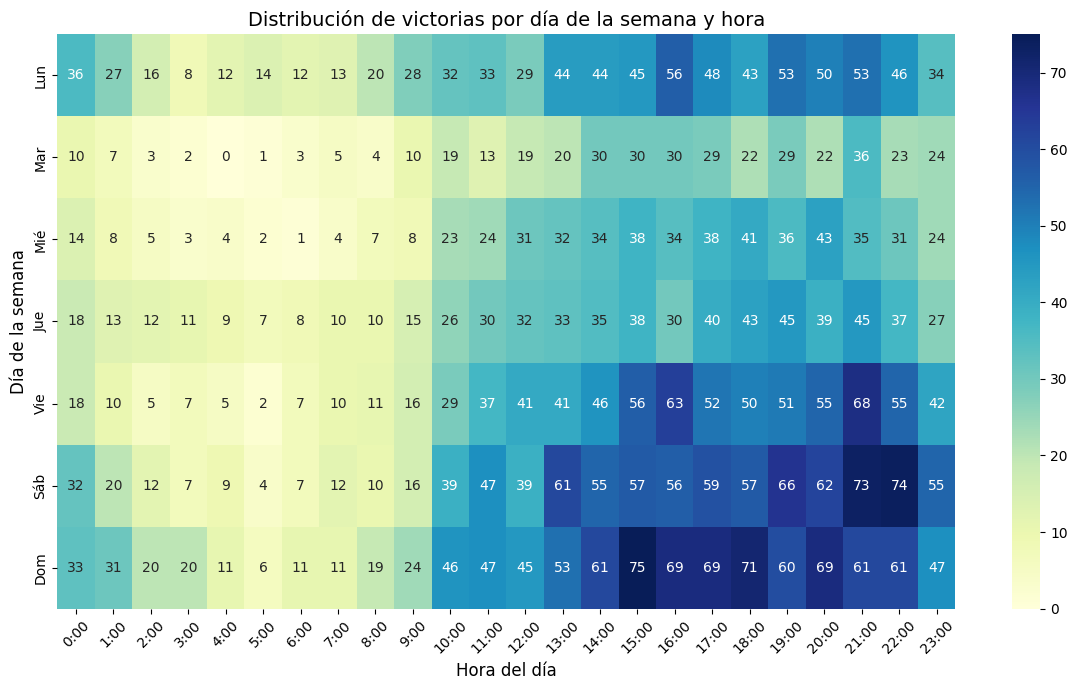

In [138]:
plt.figure(figsize=(12, 7))
sns.heatmap(win_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=True, 
            xticklabels=[f'{h}:00' for h in range(24)],  # Etiquetas para las horas
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])  # Etiquetas para días
plt.title('Distribución de victorias por día de la semana y hora', fontsize=14)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Día de la semana', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout() 
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1539042336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1539042336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour


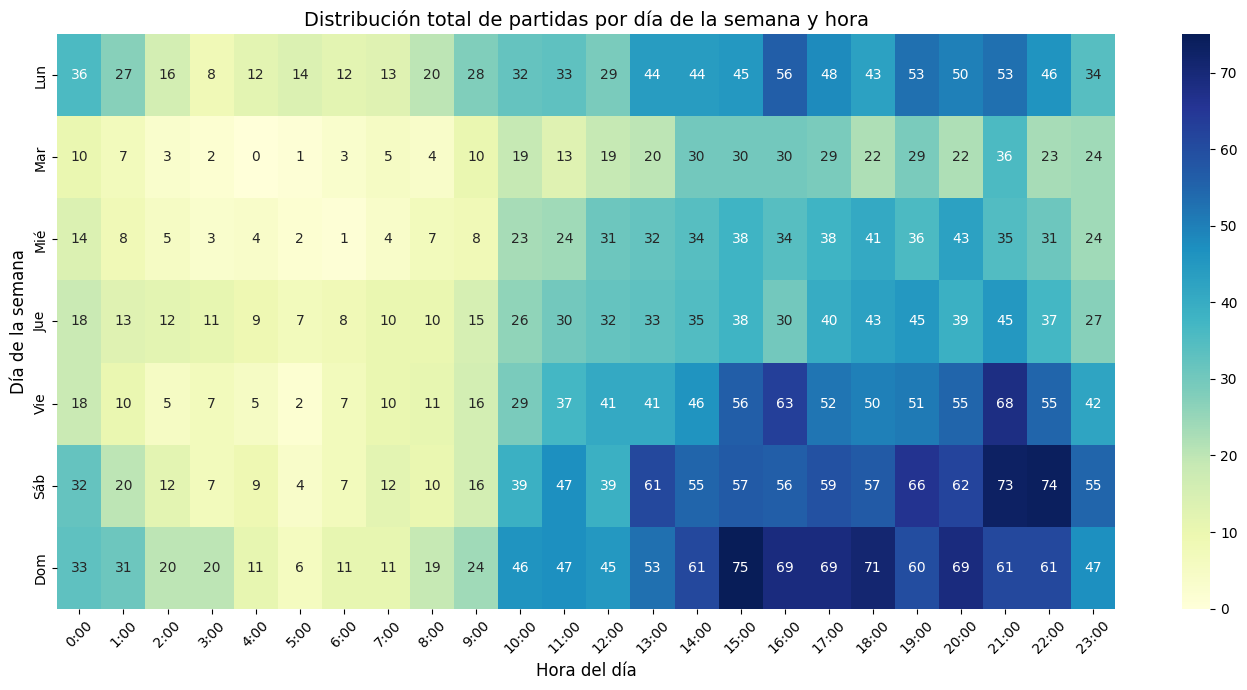

In [139]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

df_ultimo_parche['hour_of_day'] = df_ultimo_parche['game_creation'].dt.hour

# Conteo total de partidas únicas por día y hora
total_counts = (
    df_ultimo_parche.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique() 
    .unstack(fill_value=0)  
)

plt.figure(figsize=(14, 7))
sns.heatmap(total_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=True, 
            xticklabels=[f'{h}:00' for h in range(24)],  # Etiquetas para las horas
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])  # Etiquetas para días
plt.title('Distribución total de partidas por día de la semana y hora', fontsize=14)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Día de la semana', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  
plt.show()


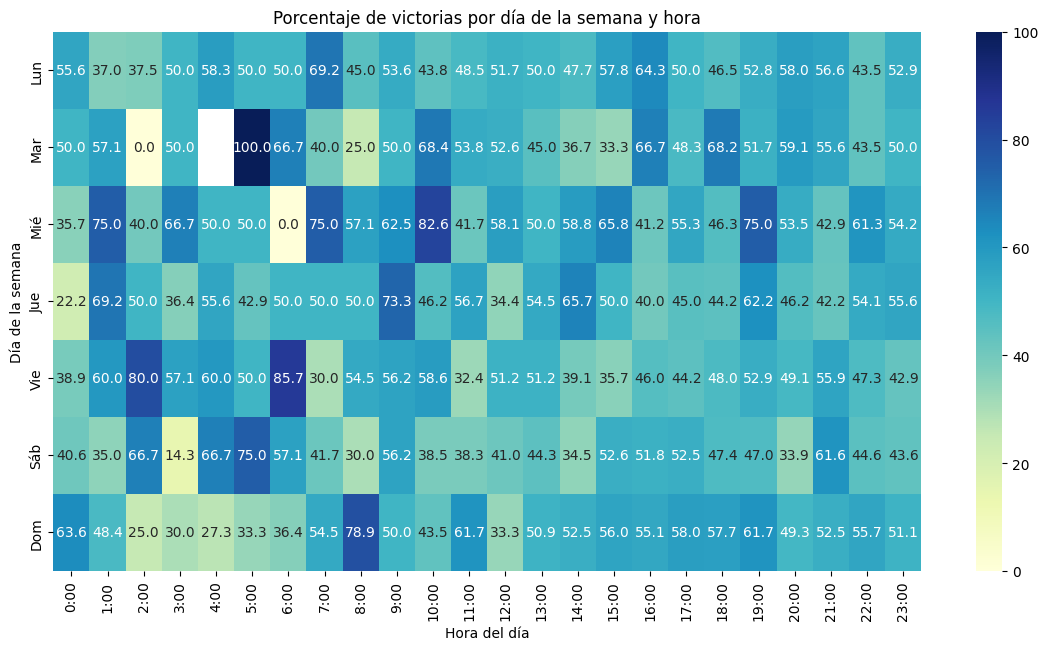

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_unique_matches = df_ultimo_parche.groupby('match_id').first().reset_index()

df_unique_matches['game_creation'] = pd.to_datetime(df_unique_matches['game_creation'], unit='ms')
df_unique_matches['day_of_week'] = df_unique_matches['game_creation'].dt.dayofweek
df_unique_matches['hour_of_day'] = df_unique_matches['game_creation'].dt.hour

# Total de partidas jugadas por día y hora
total_games = (
    df_unique_matches.groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # cuenta partidas únicas
    .unstack(fill_value=0)  
)

# Total de partidas ganadas por día y hora
total_wins = (
    df_unique_matches[df_unique_matches['win'] == True]
    .groupby(['day_of_week', 'hour_of_day'])['match_id']
    .nunique()  # cuenta partidas ganadas únicas
    .unstack(fill_value=0)  
)

# % de victorias
win_percentage = (total_wins / total_games) * 100

plt.figure(figsize=(14, 7))
sns.heatmap(win_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, 
            xticklabels=['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00',
                         '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
            yticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

plt.title('Porcentaje de victorias por día de la semana y hora')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')
plt.show()


In [141]:
df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')

# fechas mínima y máxima
fecha_min = df_ultimo_parche['game_end_timestamp'].min()
fecha_max = df_ultimo_parche['game_end_timestamp'].max()

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")

Fecha mínima: 2024-11-20 09:25:04.616000
Fecha máxima: 2024-12-10 00:23:01.768000


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1349592919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')


### Análisis de la relación entre la selección de campeones y la tasa de victoria según el día.

Este análisis ayuda a identificar campeones más efectivos por día. Se podría descubrir que ciertos campeones tienen mayores tasas de victoria en días específicos. Esto podría deberse a que los jugadores que los seleccionan son más experimentados o porque hay menos competencia contra ciertos estilos de juego en esos días.

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\709125517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')


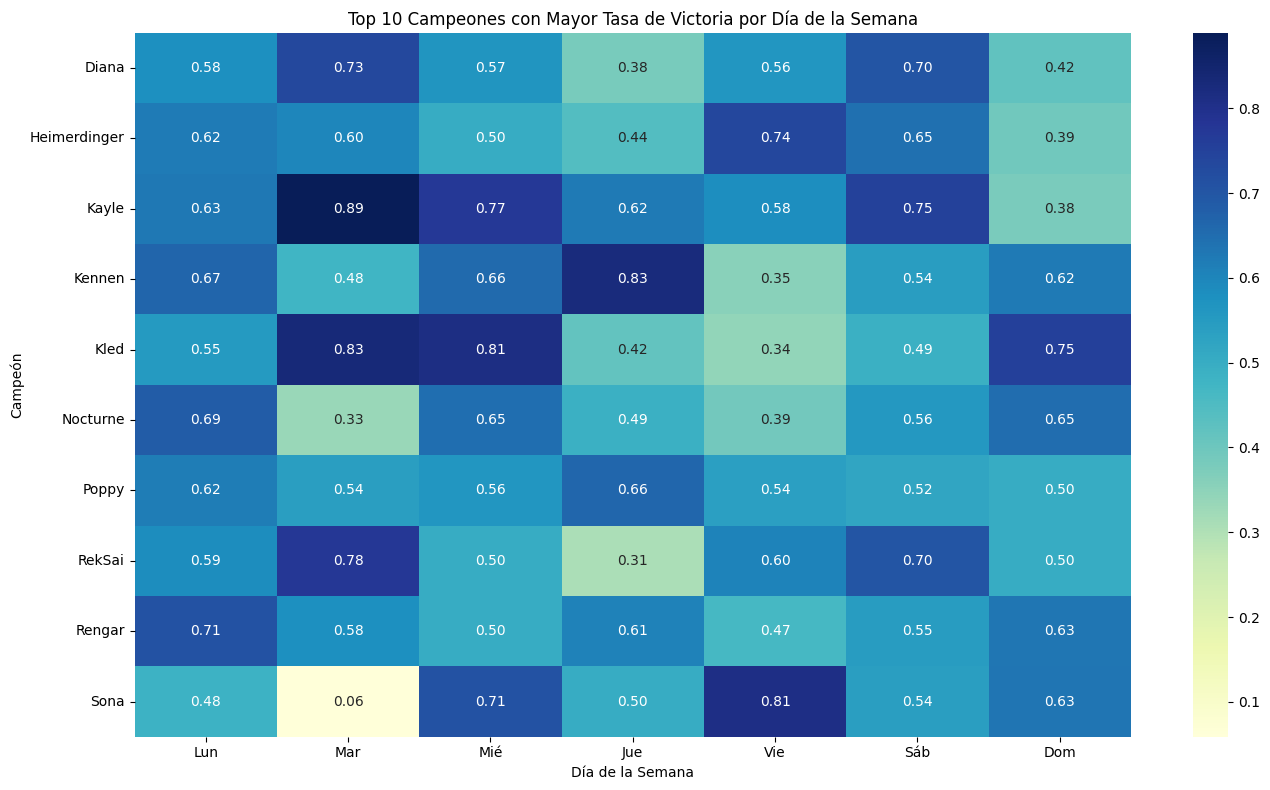

In [142]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Calculo la tasa de victoria global por campeón
win_rates = df_ultimo_parche.groupby('champion_name')['win'].mean().reset_index()
win_rates.rename(columns={'win': 'global_win_rate'}, inplace=True)

# Ordeno por tasa de victoria y selecciona los 10 mejores campeones
top_10_champions = win_rates.sort_values(by='global_win_rate', ascending=False).head(10)['champion_name']

# Filtro el dataframe original para incluir solo los top 10 campeones
df_top_10_champions = df_ultimo_parche[df_ultimo_parche['champion_name'].isin(top_10_champions)]

# Agrupo por campeón y día de la semana para calcular tasa de victoria
champion_day_stats_grouped = df_top_10_champions.groupby(['champion_name', 'day_of_week']).agg(
    total_games=('win', 'size'),
    wins=('win', 'sum')
).reset_index()

# Calculo la tasa de victoria
champion_day_stats_grouped['win_rate'] = champion_day_stats_grouped['wins'] / champion_day_stats_grouped['total_games']
pivot_table = champion_day_stats_grouped.pivot(index='champion_name', columns='day_of_week', values='win_rate')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
            xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'],
            yticklabels=pivot_table.index)

plt.title('Top 10 Campeones con Mayor Tasa de Victoria por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Campeón')
plt.tight_layout()
plt.show()


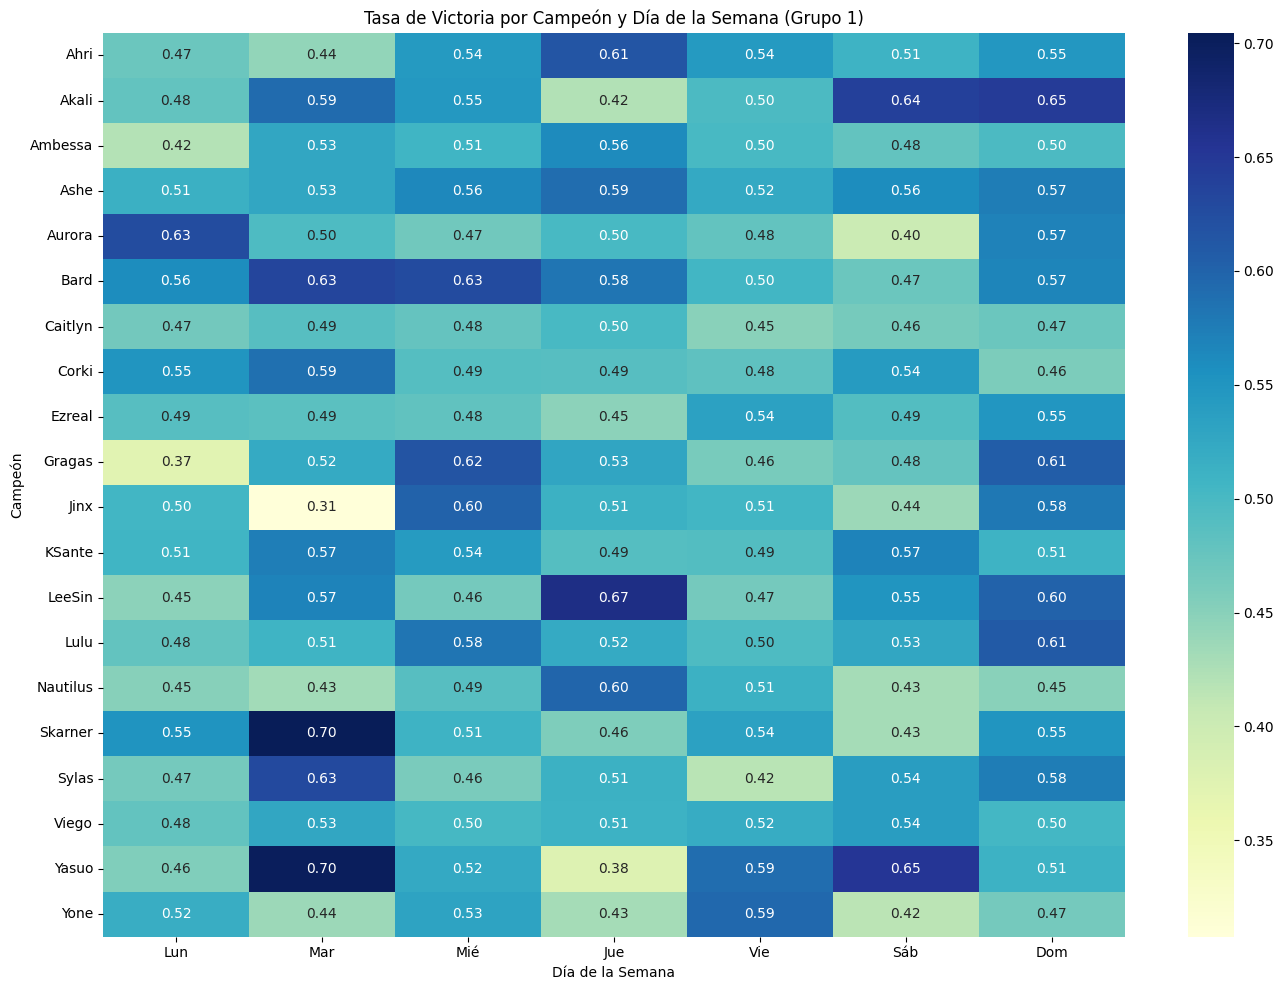

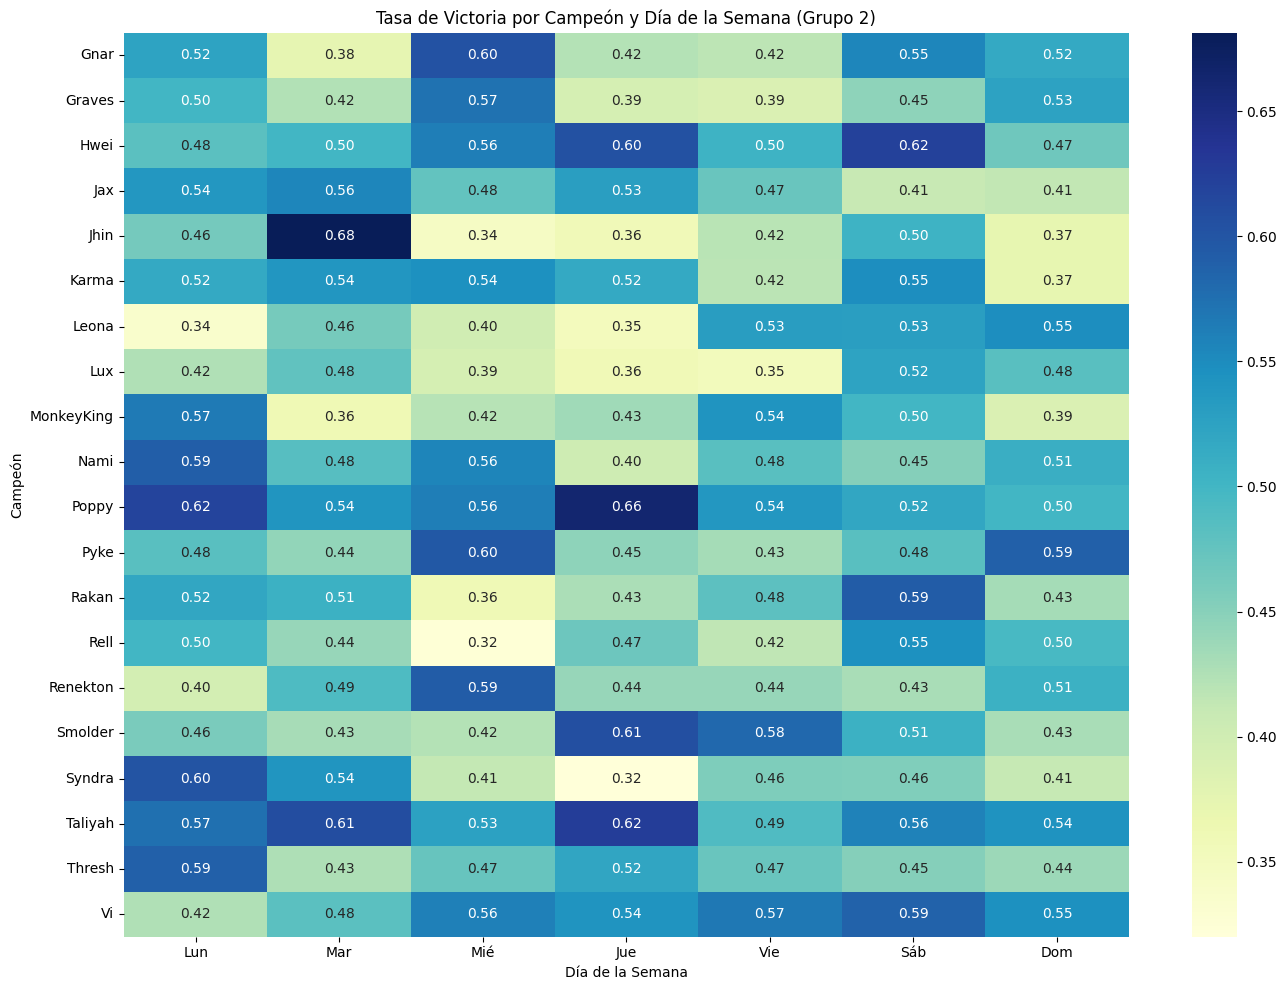

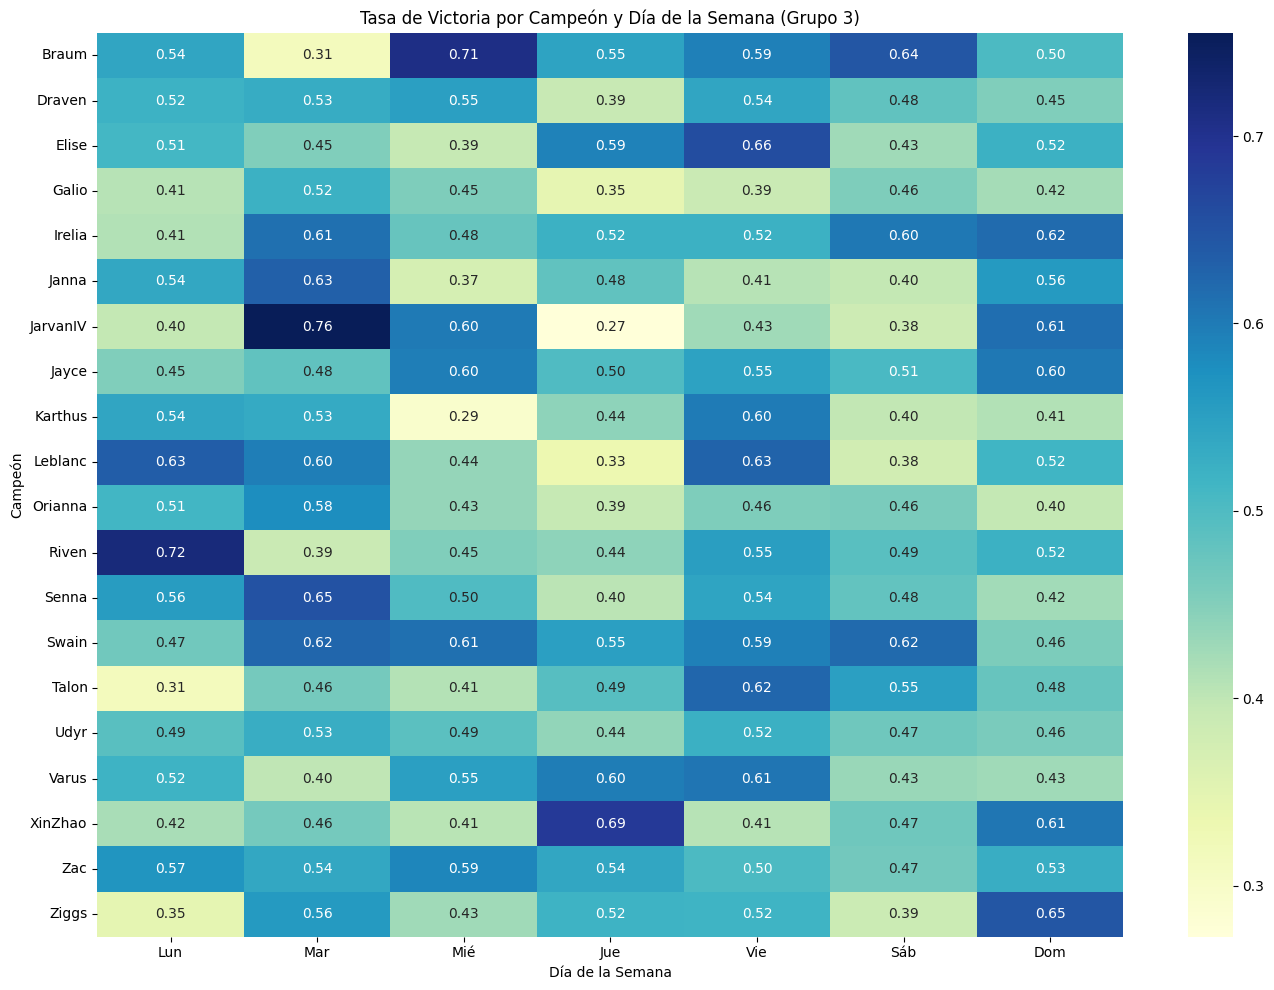

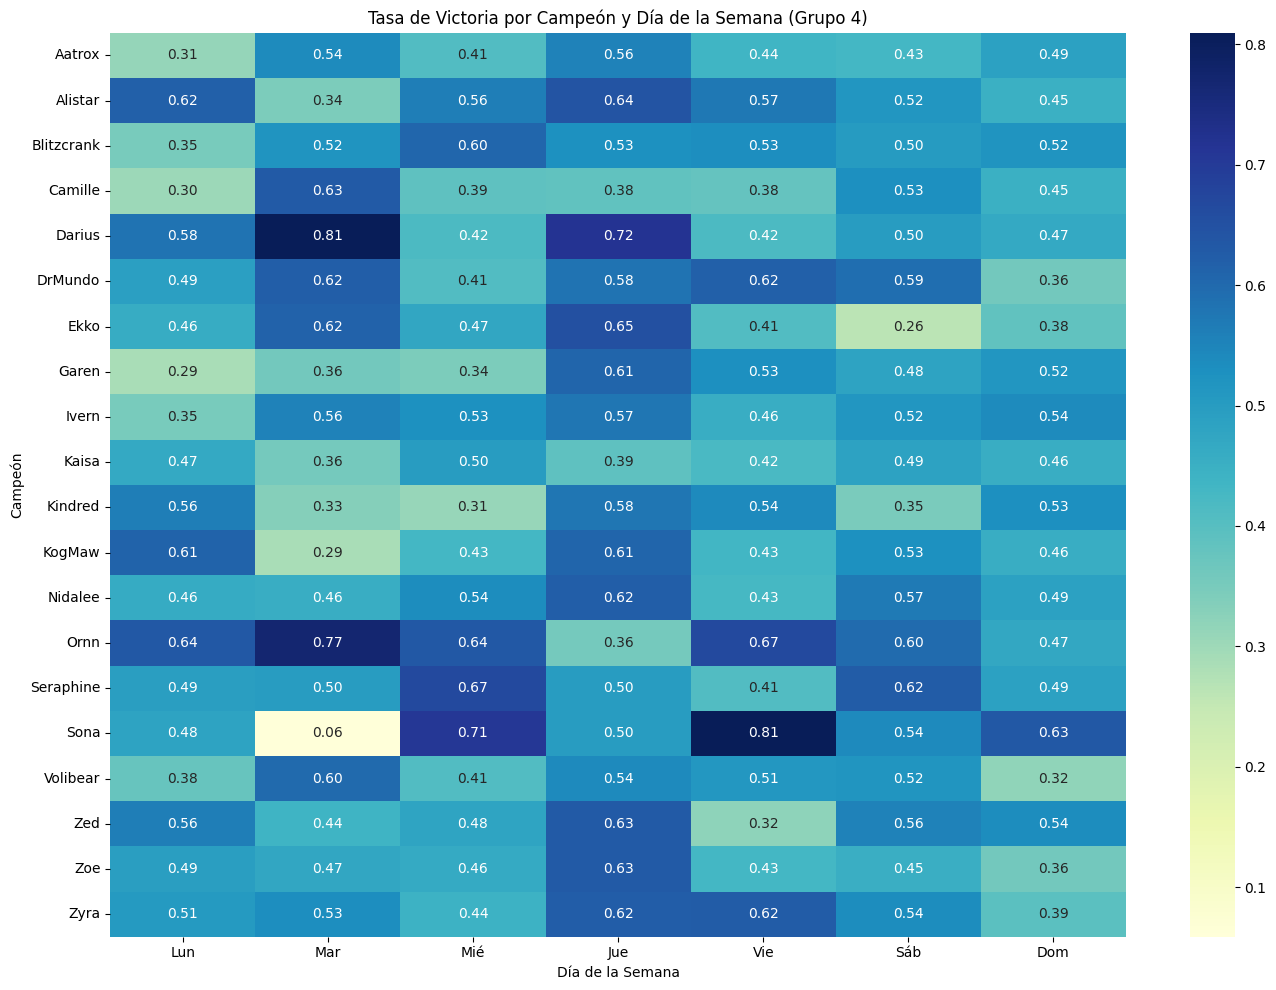

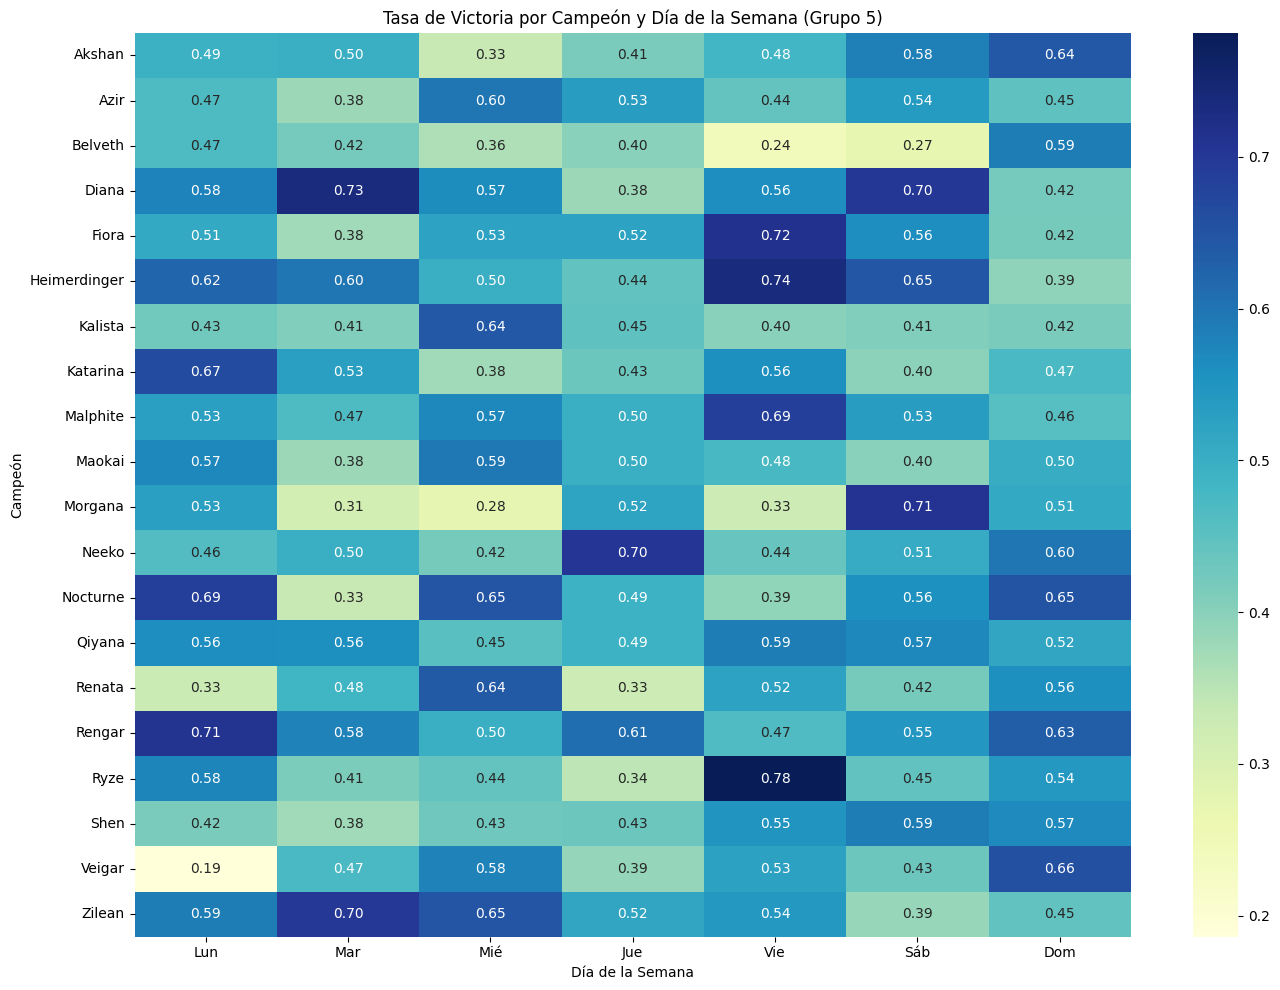

In [227]:
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# campeones más jugados
top_champions = df_ultimo_parche['champion_name'].value_counts().head(100).index  # Ajusta el número si es necesario

df_top_champions = df_ultimo_parche[df_ultimo_parche['champion_name'].isin(top_champions)]

# Cuento el total de partidas y victorias por campeón y día de la semana
champion_day_stats_grouped = df_top_champions.groupby(['champion_name', 'day_of_week']).agg(
    total_games=('win', 'size'),
    wins=('win', 'sum')
).reset_index()

# Calculo la tasa de victoria
champion_day_stats_grouped['win_rate'] = champion_day_stats_grouped['wins'] / champion_day_stats_grouped['total_games']

# Divide los campeones en grupos y crear múltiples gráficos
champions_per_plot = 20

for i in range(0, len(top_champions), champions_per_plot):
    plt.figure(figsize=(14, 10))
    sub_group = top_champions[i:i + champions_per_plot]
    temp_stats = champion_day_stats_grouped[champion_day_stats_grouped['champion_name'].isin(sub_group)]
    pivot_table = temp_stats.pivot(index='champion_name', columns='day_of_week', values='win_rate')
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, 
                xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'],
                yticklabels=pivot_table.index)
    plt.title(f'Tasa de Victoria por Campeón y Día de la Semana (Grupo {i // champions_per_plot + 1})')
    plt.xlabel('Día de la Semana')
    plt.ylabel('Campeón')
    plt.tight_layout()
    plt.show()



## Regresión Lineal

### Matriz de correlacion

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\3332770585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\3332770585.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\3332770585.py:13: SettingW

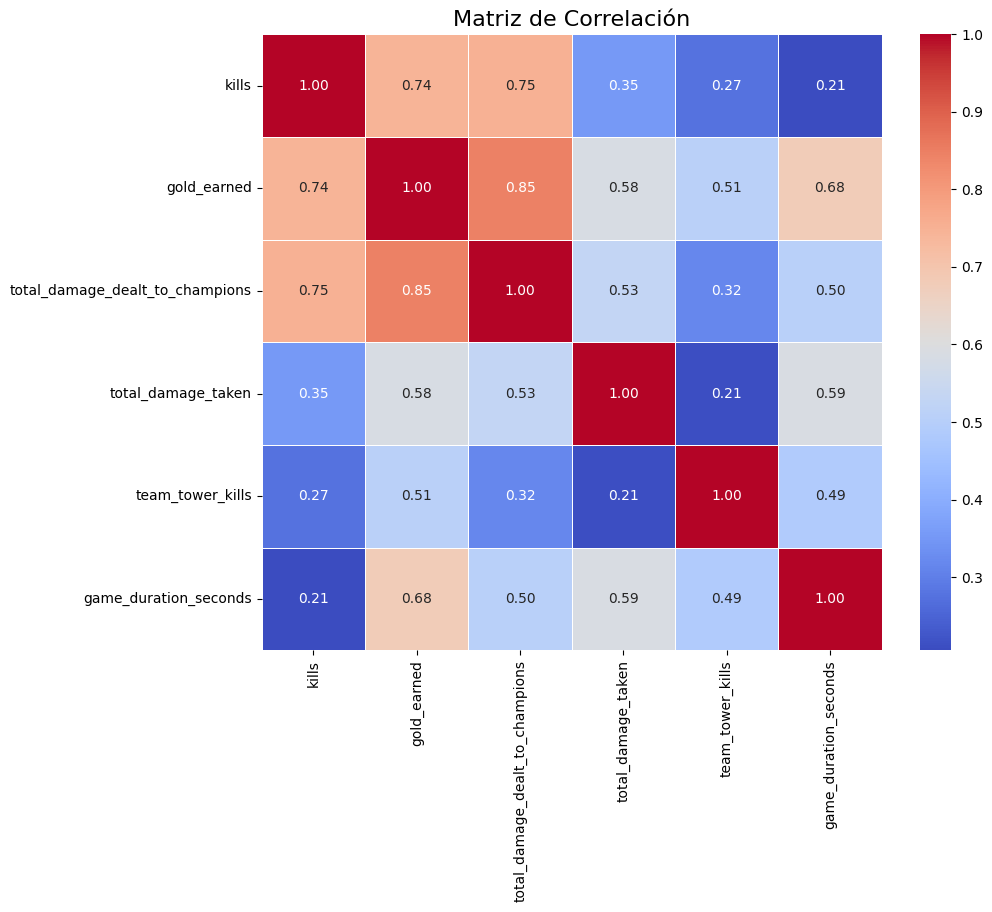

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_ultimo_parche['game_start_timestamp'] = pd.to_datetime(df_ultimo_parche['game_start_timestamp'], unit='ms')
df_ultimo_parche['game_end_timestamp'] = pd.to_datetime(df_ultimo_parche['game_end_timestamp'], unit='ms')

# Calcula la duración en segundos de la partida
df_ultimo_parche['game_duration_seconds'] = (df_ultimo_parche['game_end_timestamp'] - df_ultimo_parche['game_start_timestamp']).dt.total_seconds()

# modifica variable 'win' como un entero
df_ultimo_parche['win_encoded'] = df_ultimo_parche['win'].astype(int)

# elimino columnas no necesarias para el análisis
df_cleaned = df_ultimo_parche.drop(columns=['data_version','team_id','champion_id','deaths','assists','vision_score','match_id', 'participants', 'summoner_name', 'champion_name', 'game_mode', 'game_version', 'lane', 'role', 'day_name', 'game_date', 'day', 'time_played', 'game_duration'])

# Selecciona solo columnas numéricas
df_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()



Correlacion de variables:
gold_earned y kills: 0.742 => un mayor número de asesinatos está relacionado con más oro ganado.

gold_earned y total_damage_dealt_to_champions: 0.843 => indica que hay una relación fuerte entre el oro ganado y el daño infligido a los campeones.

kills y total_damage_dealt_to_champions: 0.751 => los jugadores que hacen más asesinatos tienden a infligir más daño a los campeones.

deaths y total_damage_taken => 0.531, lo que sugiere que los jugadores que mueren más suelen recibir más daño.

### Análisis de regresión de número de partidas que van a jugar el resto de semanas del mes de Diciembre

In [150]:
df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')

#ayudará a capturar patrones de comportamiento semanal y mensual
df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
df_ultimo_parche['day_of_month'] = df_ultimo_parche['game_date'].dt.day


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\4269639944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['game_date'] = pd.to_datetime(df_ultimo_parche['game_date'], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\4269639944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_of_week'] = df_ultimo_parche['game_date'].dt.dayofweek
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\4269639944.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [151]:
tabla_game_count = game_count_by_date.reset_index()

print("Número partidas jugadas por día:")
print(tabla_game_count)


Número partidas jugadas por día:
     game_date  game_counter
0   2024-11-20            86
1   2024-11-21           121
2   2024-11-22           100
3   2024-11-23           117
4   2024-11-24           146
5   2024-11-25           156
6   2024-11-26           210
7   2024-11-27           267
8   2024-11-28           308
9   2024-11-29           399
10  2024-11-30           472
11  2024-12-01           452
12  2024-12-02           214
13  2024-12-03           181
14  2024-12-04           167
15  2024-12-05           184
16  2024-12-06           278
17  2024-12-07           340
18  2024-12-08           422
19  2024-12-09           426


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\468632260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\468632260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_10584\468632260.py:11: FutureWarning: The default of observ

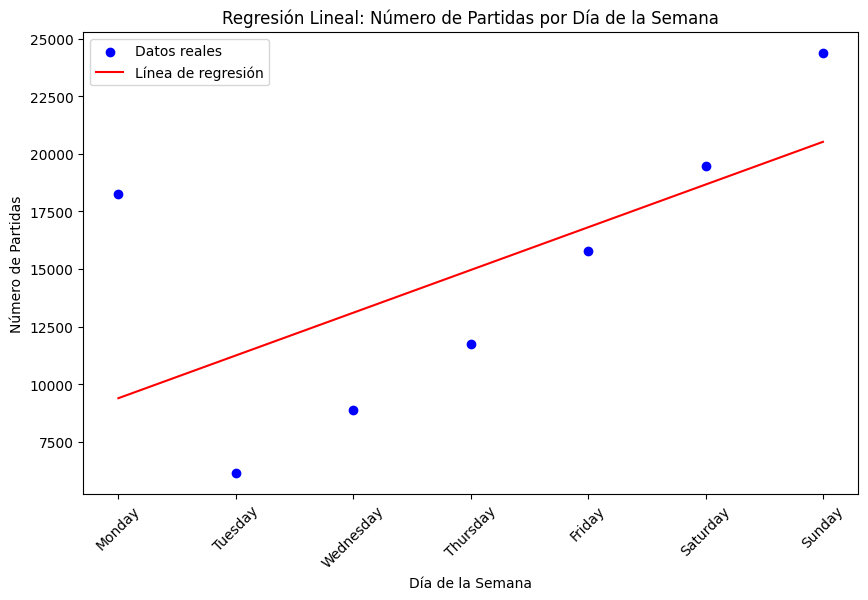

R² : 0.39


In [152]:
from sklearn.linear_model import LinearRegression
import numpy as np                                                                              X

# Creacion de la columna con el día de la semana
df_ultimo_parche['day_name'] = df_ultimo_parche['game_creation'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ultimo_parche['day_name'] = pd.Categorical(df_ultimo_parche['day_name'], categories=ordered_days, ordered=True)

# DataFrame con el número de partidas por día
game_count_by_day = df_ultimo_parche.groupby('day_name').size().reindex(ordered_days)

# se convierte los días de la semana a números (0: Lunes, ..., 6: Domingo)
X = np.arange(len(ordered_days)).reshape(-1, 1)  # Variable independiente: 0 a 6
y = game_count_by_day.values  # Variable dependiente: número de partidas
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Datos reales')  # Puntos reales
plt.plot(X, y_pred, color='red', label='Línea de regresión')  # Línea de regresión
plt.xticks(ticks=range(7), labels=ordered_days, rotation=45)
plt.title('Regresión Lineal: Número de Partidas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Partidas')
plt.legend()
plt.show()

r2_score = model.score(X, y)
print(f"R² : {r2_score:.2f}")


### Predicción para el resto del mes de Diciembre

In [155]:
future_days = np.arange(1, 30).reshape(-1, 1)
future_predictions = model.predict(future_days)

print("Predicciones para la semana siguiente:")
for i, pred in enumerate(future_predictions):
    print(f"Día {i + 3}: {int(pred)} partidas")


Predicciones para la semana siguiente:
Día 3: 11242 partidas
Día 4: 13099 partidas
Día 5: 14955 partidas
Día 6: 16812 partidas
Día 7: 18668 partidas
Día 8: 20525 partidas
Día 9: 22381 partidas
Día 10: 24237 partidas
Día 11: 26094 partidas
Día 12: 27950 partidas
Día 13: 29807 partidas
Día 14: 31663 partidas
Día 15: 33520 partidas
Día 16: 35376 partidas
Día 17: 37232 partidas
Día 18: 39089 partidas
Día 19: 40945 partidas
Día 20: 42802 partidas
Día 21: 44658 partidas
Día 22: 46514 partidas
Día 23: 48371 partidas
Día 24: 50227 partidas
Día 25: 52084 partidas
Día 26: 53940 partidas
Día 27: 55797 partidas
Día 28: 57653 partidas
Día 29: 59509 partidas
Día 30: 61366 partidas
Día 31: 63222 partidas


### Predicción diaria del mes de Diciembre

#### Prediccion para diciembre

### KDA + asistencias / muertes

In [22]:
df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']

df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], float('nan'))

In [23]:
# Filtrar filas sin nombre de invocador o con valores nulos en KDA
df_valid_kda = df_ultimo_parche.dropna(subset=['summoner_name', 'kda'])

# Opcional: Filtrar jugadores con al menos 10 partidas jugadas
player_counts = df_valid_kda['summoner_name'].value_counts()
valid_players = player_counts[player_counts >= 10].index
df_valid_kda = df_valid_kda[df_valid_kda['summoner_name'].isin(valid_players)]

# Calcular KDA promedio por jugador
top_players_kda = df_valid_kda.groupby('summoner_name')['kda'].mean().sort_values(ascending=False)



In [24]:
# Obtener el top 10
top_10_kda = top_players_kda.head(10)

# Mostrar el resultado
top_10_kda


summoner_name
itsalreadyjggap    15.232071
Ruck Fıto          10.958929
Fleshyy            10.263762
IntAcc999           9.247024
SK Nenrislol        8.929323
Remy Albers         8.785000
eltuko              8.732957
al Asad             8.625000
zoed                8.382653
Qiú yú shén         8.087662
Name: kda, dtype: float64

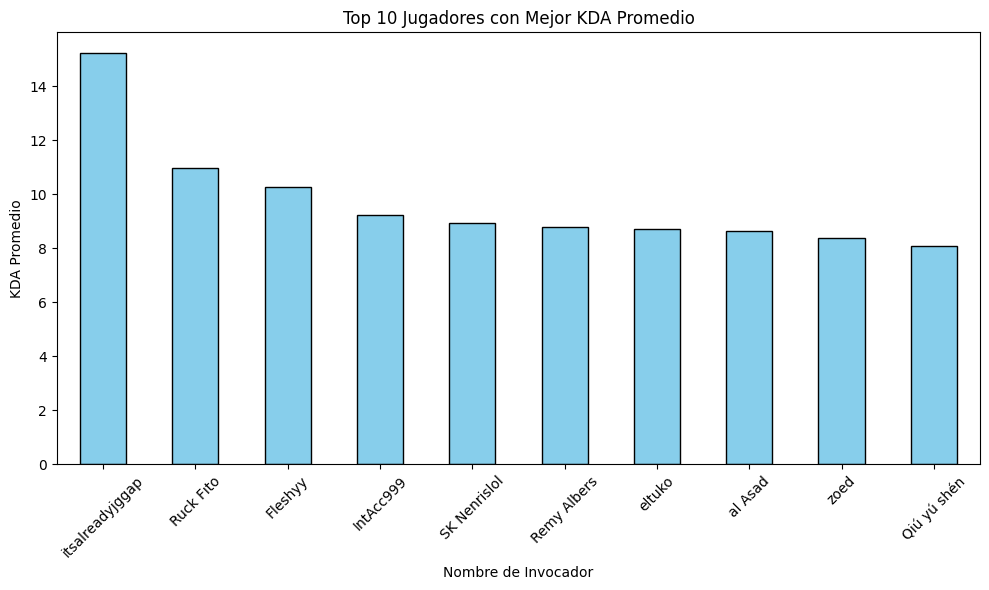

In [25]:
# Crear un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_10_kda.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Jugadores con Mejor KDA Promedio')
plt.xlabel('Nombre de Invocador')
plt.ylabel('KDA Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
# Obtener el top 10
top_10_kda = top_players_kda.head(10).reset_index()

# Mostrar el resultado
top_10_kda

,summoner_name,kda
0,itsalreadyjggap,15.232071
1,Ruck Fıto,10.958929
2,Fleshyy,10.263762
3,IntAcc999,9.247024
4,SK Nenrislol,8.929323
5,Remy Albers,8.785000
6,eltuko,8.732957
7,al Asad,8.625000
8,zoed,8.382653
9,Qiú yú shén,8.087662


In [27]:
# filtracion de los datos de df_ultimo_parche usando el top 10 de jugadores kda
player_data_top = df_ultimo_parche[df_ultimo_parche['summoner_name'].isin(top_10_kda['summoner_name'])]
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')

player_data_top.head(8)


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\930400504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')


,match_id,data_version,participants,game_creation,game_duration,game_end_timestamp,game_start_timestamp,game_mode,game_version,team_id,...,first_dragon,first_inhibitor,team_tower_kills,game_date,day,day_of_week,day_type,day_name,hour_of_day,kda
573,EUW1_7218556505,2,['GKipOcl3O7U4mALHDeCrLn9u8PRZLmaciwjKUo5_gMtK...,2024-12-07 16:27:32.256,924,2024-12-07 16:43:19.139,2024-12-07 16:27:54.751,CLASSIC,14.23.636.9832,100,...,False,False,4,2024-12-07,2024-12-07,5,Fin de semana,Saturday,16,8.000000
1226,EUW1_7220808691,2,['AXlmOSjedq9ZM9UXT3QKtK6NV1wC9FXrR7S3bAfP4RHh...,2024-12-09 04:49:27.198,2262,2024-12-09 05:28:18.274,2024-12-09 04:50:36.162,CLASSIC,14.23.636.9832,200,...,False,True,7,2024-12-09,2024-12-09,0,Laboral,Monday,4,2.857143
2343,EUW1_7218974320,2,['LdYO6Gtw8oAdh5N9brxQtIF_Vhsqy1XbSw0_vJv82pw6...,2024-12-07 21:16:07.359,1578,2024-12-07 21:42:40.310,2024-12-07 21:16:22.275,CLASSIC,14.23.636.9832,100,...,False,True,10,2024-12-07,2024-12-07,5,Fin de semana,Saturday,21,24.000000
3221,EUW1_7219889830,2,['r7ivDzcti2wF-8vDAWkQYWQQOdy9C6UFBpHauRZE6UuY...,2024-12-08 15:36:10.752,1105,2024-12-08 15:55:19.574,2024-12-08 15:36:54.016,CLASSIC,14.23.636.9832,100,...,False,False,4,2024-12-08,2024-12-08,6,Fin de semana,Sunday,15,3.750000
3536,EUW1_7203969313,2,['m3aWDxHo18QoWU-7wn6tOjUb10MWgD8xVIurtTDEY6Qm...,2024-11-27 13:09:47.152,1706,2024-11-27 13:38:41.489,2024-11-27 13:10:15.186,CLASSIC,14.23.636.9832,200,...,True,True,9,2024-11-27,2024-11-27,2,Laboral,Wednesday,13,11.666667
3936,EUW1_7220808691,2,['AXlmOSjedq9ZM9UXT3QKtK6NV1wC9FXrR7S3bAfP4RHh...,2024-12-09 04:49:27.198,2262,2024-12-09 05:28:18.274,2024-12-09 04:50:36.162,CLASSIC,14.23.636.9832,200,...,False,True,7,2024-12-09,2024-12-09,0,Laboral,Monday,4,2.857143
5014,EUW1_7197771956,2,['LiaWn_06b_Xj5KkhZwZSqvubPS5kZNDu7lLLdjAbi0O4...,2024-11-23 13:40:55.397,1700,2024-11-23 14:09:29.917,2024-11-23 13:41:10.014,CLASSIC,14.23.636.9832,100,...,True,True,8,2024-11-23,2024-11-23,5,Fin de semana,Saturday,13,21.000000
5148,EUW1_7217101617,2,['-8__86a96SEBK8W78TRdD0Ui2jkD0kmmpc2ntz4q215Z...,2024-12-06 15:46:32.487,1144,2024-12-06 16:06:54.844,2024-12-06 15:47:50.215,CLASSIC,14.23.636.9832,200,...,False,True,10,2024-12-06,2024-12-06,4,Laboral,Friday,15,4.000000


In [198]:
player_data_top.columns

Index(['match_id', 'data_version', 'participants', 'game_creation',
       'game_duration', 'game_end_timestamp', 'game_start_timestamp',
       'game_mode', 'game_version', 'team_id', 'summoner_name',
       'champion_name', 'champion_id', 'kills', 'deaths', 'assists',
       'gold_earned', 'win', 'lane', 'role', 'vision_score',
       'total_damage_dealt_to_champions', 'total_damage_taken', 'time_played',
       'team_position', 'team_win', 'team_first_blood', 'team_first_tower',
       'first_baron', 'first_dragon', 'first_inhibitor', 'team_tower_kills',
       'kda', 'game_date'],
      dtype='object')

In [28]:
player_data_top['summoner_name'].unique()

array(['SK Nenrislol', 'Qiú yú shén', 'eltuko', 'al Asad', 'Fleshyy',
       'IntAcc999', 'Ruck Fıto', 'zoed', 'itsalreadyjggap', 'Remy Albers'],
      dtype=object)

In [29]:
# se elimina los duplicados basados en match_id y summoner_name
#player_data_top_info = player_data_top.drop_duplicates(subset=['match_id', 'summoner_name'])

# Agrupa por summoner_name y sumar el tiempo jugado
player_time_played = (
    player_data_top
    .groupby('summoner_name')['time_played']
    .sum()
    .reset_index()
)

# se convierte a minutos
player_time_played['time_played_minuts'] = player_time_played['time_played'] / 60

#player_time_played.drop('time_played', axis=1, inplace=True)


#lo paso a serie para hacer el grafico
time_played_series = player_time_played.set_index('summoner_name')['time_played_minuts']

time_played_series #obtengo los minutos totales que ha jugado cada jugador de todas sus partidas.


summoner_name
Fleshyy            659.033333
IntAcc999          361.733333
Qiú yú shén        342.933333
Remy Albers        312.700000
Ruck Fıto          346.833333
SK Nenrislol       433.566667
al Asad            315.866667
eltuko             420.000000
itsalreadyjggap    395.216667
zoed               389.166667
Name: time_played_minuts, dtype: float64

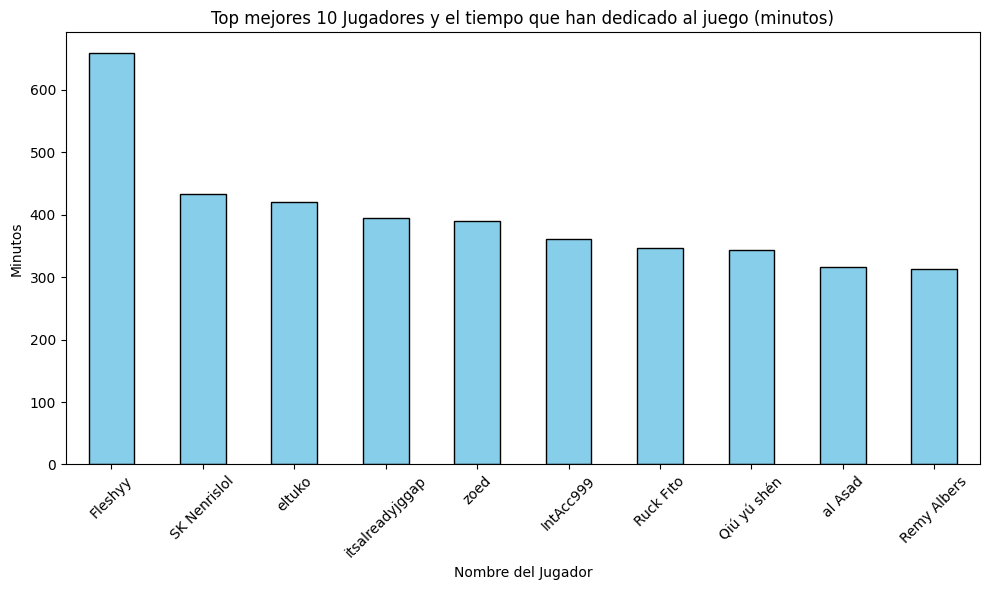

In [40]:
time_played_series = time_played_series.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
time_played_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top mejores 10 Jugadores y el tiempo que han dedicado al juego (minutos)')
plt.xlabel('Nombre del Jugador')
plt.ylabel('Minutos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
#el dataframe player_data_top tengo todas las columnas de df_ultimo_parche, pero está filtrado por los jugadores top 10 de kda.
player_data_top = player_data_top.copy()
player_data_top['time_played_minuts'] = player_data_top['time_played'] / 60

player_data_top.head(6).to_csv("borrar2.csv")

In [38]:
#Obtengo el numero de partidas totales por día

# se convierte la columna 'game_creation' a formato datetime
df_ultimo_parche['game_creation'] = pd.to_datetime(df_ultimo_parche['game_creation'], unit='ms')

# Crea una columna con la fecha (sin hora) para agrupar los datos por día
df_ultimo_parche['game_date'] = df_ultimo_parche['game_creation'].dt.date

# Cuenta número de partidas únicas por cada día
game_count_by_date = df_ultimo_parche.groupby('game_date')['match_id'].nunique()

game_count_by_date

game_date
2024-11-20     86
2024-11-21    121
2024-11-22    100
2024-11-23    117
2024-11-24    146
2024-11-25    156
2024-11-26    210
2024-11-27    267
2024-11-28    308
2024-11-29    399
2024-11-30    472
2024-12-01    452
2024-12-02    214
2024-12-03    181
2024-12-04    167
2024-12-05    184
2024-12-06    278
2024-12-07    340
2024-12-08    422
2024-12-09    426
Name: match_id, dtype: int64

In [37]:
player_data_top

,match_id,data_version,participants,game_creation,game_duration,game_end_timestamp,game_start_timestamp,game_mode,game_version,team_id,...,first_dragon,first_inhibitor,team_tower_kills,game_date,day,day_of_week,day_type,day_name,hour_of_day,kda
573,EUW1_7218556505,2,['GKipOcl3O7U4mALHDeCrLn9u8PRZLmaciwjKUo5_gMtK...,2024-12-07 16:27:32.256,924,2024-12-07 16:43:19.139,2024-12-07 16:27:54.751,CLASSIC,14.23.636.9832,100,...,False,False,4,2024-12-07,2024-12-07,5,Fin de semana,Saturday,16,8.000000
1226,EUW1_7220808691,2,['AXlmOSjedq9ZM9UXT3QKtK6NV1wC9FXrR7S3bAfP4RHh...,2024-12-09 04:49:27.198,2262,2024-12-09 05:28:18.274,2024-12-09 04:50:36.162,CLASSIC,14.23.636.9832,200,...,False,True,7,2024-12-09,2024-12-09,0,Laboral,Monday,4,2.857143
2343,EUW1_7218974320,2,['LdYO6Gtw8oAdh5N9brxQtIF_Vhsqy1XbSw0_vJv82pw6...,2024-12-07 21:16:07.359,1578,2024-12-07 21:42:40.310,2024-12-07 21:16:22.275,CLASSIC,14.23.636.9832,100,...,False,True,10,2024-12-07,2024-12-07,5,Fin de semana,Saturday,21,24.000000
3221,EUW1_7219889830,2,['r7ivDzcti2wF-8vDAWkQYWQQOdy9C6UFBpHauRZE6UuY...,2024-12-08 15:36:10.752,1105,2024-12-08 15:55:19.574,2024-12-08 15:36:54.016,CLASSIC,14.23.636.9832,100,...,False,False,4,2024-12-08,2024-12-08,6,Fin de semana,Sunday,15,3.750000
3536,EUW1_7203969313,2,['m3aWDxHo18QoWU-7wn6tOjUb10MWgD8xVIurtTDEY6Qm...,2024-11-27 13:09:47.152,1706,2024-11-27 13:38:41.489,2024-11-27 13:10:15.186,CLASSIC,14.23.636.9832,200,...,True,True,9,2024-11-27,2024-11-27,2,Laboral,Wednesday,13,11.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110903,EUW1_7208785296,2,['JjVqCckqt9IceqraOtpUYlLVP1NeffcAAmcCsuYk8MRd...,2024-11-30 17:11:21.010,1802,2024-11-30 17:41:38.150,2024-11-30 17:11:35.695,CLASSIC,14.23.636.9832,100,...,False,False,8,2024-11-30,2024-11-30,5,Fin de semana,Saturday,17,29.000000
111836,EUW1_7209930267,2,['_AeHhfM78rzjxs-Ym3xXO8glQe6S-cLQGlmVZV03AZlK...,2024-12-01 12:13:13.864,1500,2024-12-01 12:38:45.561,2024-12-01 12:13:45.055,CLASSIC,14.23.636.9832,200,...,True,True,7,2024-12-01,2024-12-01,6,Fin de semana,Sunday,12,28.000000
111841,EUW1_7209882382,2,['aKGO3bBxBOL17jVls0FhzNpPXTD7hlTnY12ccK1E8mVk...,2024-12-01 11:35:10.853,1836,2024-12-01 12:06:15.801,2024-12-01 11:35:39.321,CLASSIC,14.23.636.9832,100,...,False,False,3,2024-12-01,2024-12-01,6,Fin de semana,Sunday,11,4.000000
112472,EUW1_7209714645,2,['FPnIPAZbbSRffXRF43umhWBkajmklwFbZ4rhuJ9-WF0O...,2024-12-01 07:14:09.807,1096,2024-12-01 07:32:51.567,2024-12-01 07:14:35.428,CLASSIC,14.23.636.9832,100,...,True,False,5,2024-12-01,2024-12-01,6,Fin de semana,Sunday,7,NaN


In [41]:
import pandas as pd
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'], unit='ms')

fecha_minima = player_data_top['game_creation'].min()
fecha_maxima = player_data_top['game_creation'].max()

# Filtra el DataFrame entre las fechas
print(fecha_minima,"  ",fecha_maxima)

2024-11-23 12:20:08.568000    2024-12-09 21:43:20.292000


In [34]:
player_data_top.columns

Index(['match_id', 'data_version', 'participants', 'game_creation',
       'game_duration', 'game_end_timestamp', 'game_start_timestamp',
       'game_mode', 'game_version', 'team_id', 'summoner_name',
       'champion_name', 'champion_id', 'kills', 'deaths', 'assists',
       'gold_earned', 'win', 'lane', 'role', 'vision_score',
       'total_damage_dealt_to_champions', 'total_damage_taken', 'time_played',
       'team_position', 'team_win', 'team_first_blood', 'team_first_tower',
       'first_baron', 'first_dragon', 'first_inhibitor', 'team_tower_kills',
       'game_date', 'day', 'day_of_week', 'day_type', 'day_name',
       'hour_of_day', 'kda'],
      dtype='object')

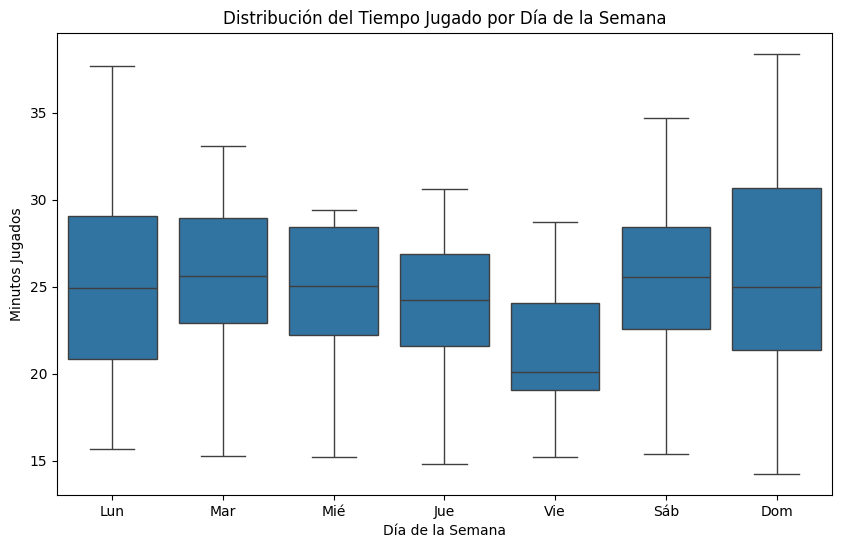

In [44]:
# Extrae el día de la semana de la columna 'game_creation'
player_data_top['day_of_week'] = player_data_top['game_creation'].dt.dayofweek

# Mapea los números de 0 a 6 a nombres abreviados de los días
day_mapping = {0: 'Lun', 1: 'Mar', 2: 'Mié', 3: 'Jue', 4: 'Vie', 5: 'Sáb', 6: 'Dom'}
player_data_top['day_of_week'] = player_data_top['day_of_week'].replace(day_mapping)

# Gráfico para analizar si existe una relación
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='time_played_minuts', data=player_data_top, order=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.title('Distribución del Tiempo Jugado por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Minutos Jugados')
plt.show()


In [46]:
# nuevo dataframe con el número total de partidas por jugador
players_top_game_counter = player_data_top.groupby('summoner_name')['match_id'].nunique().reset_index()

players_top_game_counter.rename(columns={'match_id': 'game_counter_total'}, inplace=True)

print(players_top_game_counter)

     summoner_name  game_counter_total
0          Fleshyy                   9
1        IntAcc999                   6
2      Qiú yú shén                   8
3      Remy Albers                   7
4        Ruck Fıto                   9
5     SK Nenrislol                  11
6          al Asad                   4
7           eltuko                  10
8  itsalreadyjggap                   7
9             zoed                  14


In [47]:
#Promedio de tiempo de juego dedicado por cada jugador.

avg_time_per_game = player_data_top.groupby('summoner_name')['time_played_minuts'].mean().reset_index()


avg_time_per_game.rename(columns={'time_played_minuts': 'avg_time_per_game'}, inplace=True)
print(avg_time_per_game)


     summoner_name  avg_time_per_game
0          Fleshyy          26.361333
1        IntAcc999          22.608333
2      Qiú yú shén          31.175758
3      Remy Albers          28.427273
4        Ruck Fıto          24.773810
5     SK Nenrislol          22.819298
6          al Asad          26.322222
7           eltuko          22.105263
8  itsalreadyjggap          26.347778
9             zoed          21.620370


In [48]:
# media del tiempo jugado por partida
mean_play_time = player_data_top['time_played_minuts'].mean()

# agrego la columna indicando si es un juego largo o corto, es el promedio total(partida en minutos) de los challengers
player_data_top['long_game'] = player_data_top['time_played_minuts'] > mean_play_time
# convierte la columna booleana a numérica (1 para True, 0 para False)
player_data_top['long_game'] = player_data_top['long_game'].astype(int)


In [209]:
player_data_top.to_csv("borrar2.csv")

In [49]:
player_data_top[['game_creation','time_played_minuts']]
daily_data = player_data_top[['game_creation', 'time_played_minuts']]
daily_data['game_date'] = daily_data['game_creation'].dt.date

# Agrupa por fecha y calcula el promedio de minutos jugados
avg_minutes_per_day = daily_data.groupby('game_date')['time_played_minuts'].mean()

print(avg_minutes_per_day)

game_date
2024-11-23    25.970833
2024-11-24    29.493333
2024-11-25    26.150000
2024-11-26    29.383333
2024-11-27    25.004444
2024-11-28    23.666667
2024-11-29    22.993333
2024-11-30    27.827083
2024-12-01    23.977193
2024-12-02    23.894444
2024-12-03    24.436667
2024-12-04    21.977778
2024-12-05    23.780556
2024-12-06    19.873333
2024-12-07    23.647619
2024-12-08    22.916667
2024-12-09    25.289744
Name: time_played_minuts, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\892364181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['game_date'] = daily_data['game_creation'].dt.date


## Regresion Polinomica

In [188]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [173]:
columns_to_keep = ['kda', 'gold_earned', 'total_damage_dealt_to_champions', 'time_played_minuts']

filtered_data = player_data_top[columns_to_keep]

filtered_data['kda'] = filtered_data['kda'].fillna(filtered_data['kda'].mean())

# Defino X y y
X = filtered_data.drop(columns=['time_played_minuts'])
y = filtered_data['time_played_minuts']

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1705330359.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['kda'] = filtered_data['kda'].fillna(filtered_data['kda'].mean())


In [174]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (128, 3), Test: (32, 3)


In [175]:
# Normalización de las características
scaler = StandardScaler()

# Escala datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [176]:
#Aplicacion de regresion polinomica

# generacion características polinómicas de grado 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)


In [177]:
# Evaluación del modelo
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


Train RMSE: 3.16, R²: 0.69
Test RMSE: 3.00, R²: 0.58


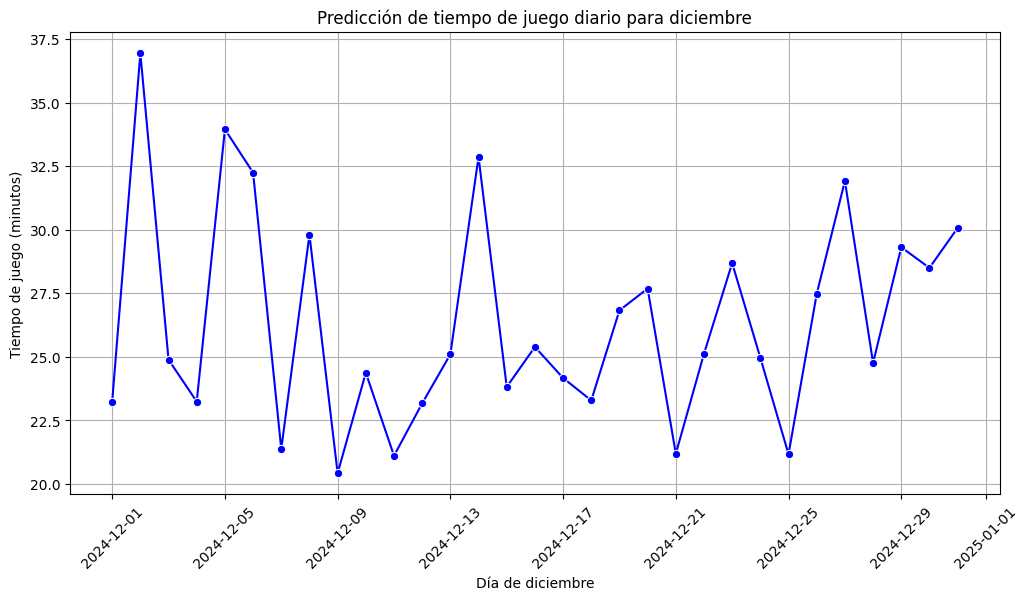

,kda,gold_earned,total_damage_dealt_to_champions,day,predicted_time_played
0,3.083873,7575.023650,19974.773098,2024-12-01,23.239158
1,2.447045,14317.591047,20761.780735,2024-12-02,36.940275
2,2.164488,9120.300819,19674.953093,2024-12-03,24.890022
3,8.509490,10633.667057,28136.377870,2024-12-04,23.242295
4,3.927314,14545.919241,27662.370118,2024-12-05,33.947441
5,5.341799,13344.702058,11924.555269,2024-12-06,32.246920
6,9.099107,6317.834194,18035.267645,2024-12-07,21.374097
7,6.504658,13464.145147,18423.810814,2024-12-08,29.803444
8,7.403254,6500.133914,15972.695196,2024-12-09,20.424346
9,5.330831,10219.364873,24789.883504,2024-12-10,24.376883


In [ ]:
# Generación de datos simulados para diciembre
diciembre_data = pd.DataFrame({
    'kda': np.random.uniform(2, 10, size=31),
    'gold_earned': np.random.uniform(5000, 15000, size=31),
    'total_damage_dealt_to_champions': np.random.uniform(10000, 30000, size=31)
    })

# Normalización de datos nuevos
diciembre_scaled = scaler.transform(diciembre_data)

# Transformación polinómica
diciembre_poly = poly.transform(diciembre_scaled)

diciembre_predictions = model.predict(diciembre_poly)

diciembre_data['day'] = pd.date_range(start='2024-12-01', periods=31, freq='D')
diciembre_data['predicted_time_played'] = diciembre_predictions

plt.figure(figsize=(12, 6))
sns.lineplot(data=diciembre_data, x='day', y='predicted_time_played', marker='o', color='b')
plt.title("Predicción de tiempo de juego diario para diciembre")
plt.xlabel("Día de diciembre")
plt.ylabel("Tiempo de juego (minutos)")
plt.xticks(rotation=45)
plt.grid()
plt.show()
diciembre_data

In [192]:
# Define el pipeline con normalización y regresión polinómica
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Rango de hiperparámetros a probar
param_grid = {
    'poly__degree': [1, 2, 3, 4]  # Grados de polinomio
}

# Configuración para la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Ejecución de la búsqueda
grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor R² obtenido: {grid_search.best_score_:.2f}")


Mejores hiperparámetros: {'poly__degree': 2}
Mejor R² obtenido: 0.62


In [190]:
# VALIDACION CRUZADA

# Modelo con transformación polinómica
grado = 2
modelo = make_pipeline(PolynomialFeatures(grado), LinearRegression())

# Configuración de la validación cruzada (K-Fold)
k = 5  # 5 folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Definir la métrica RMSE como scorer personalizado
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

# Evaluar con validación cruzada
r2_scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring='r2')
rmse_scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring=rmse_scorer)

# Resultados promedio
print(f"Cross-Validation R² Scores: {r2_scores}")
print(f"Mean Cross-Validation R²: {np.mean(r2_scores):.2f}")
print(f"Cross-Validation RMSE Scores: {-rmse_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(-rmse_scores):.2f}")



Cross-Validation R² Scores: [0.57189379 0.53874663 0.60587788 0.70802265 0.64362078]
Mean Cross-Validation R²: 0.61
Cross-Validation RMSE Scores: [3.43949467 3.89655452 3.71280573 2.71581377 3.64898289]
Mean Cross-Validation RMSE: 3.48


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared'

#### Matriz de correlacion

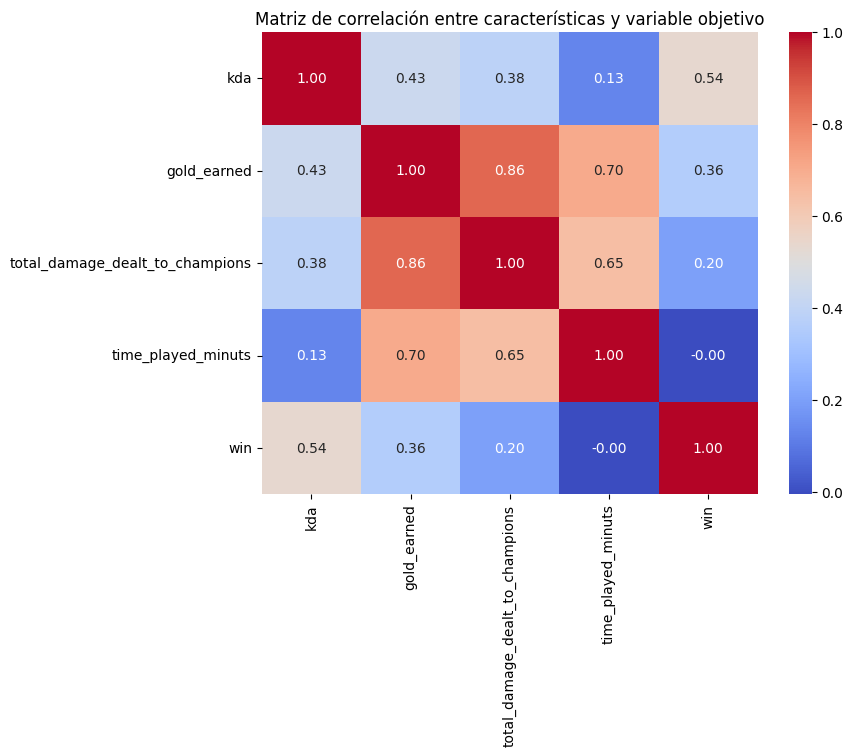

                                      kda  gold_earned  \
kda                              1.000000     0.434069   
gold_earned                      0.434069     1.000000   
total_damage_dealt_to_champions  0.384960     0.861020   
time_played_minuts               0.132647     0.704591   
win                              0.535202     0.360014   

                                 total_damage_dealt_to_champions  \
kda                                                     0.384960   
gold_earned                                             0.861020   
total_damage_dealt_to_champions                         1.000000   
time_played_minuts                                      0.645770   
win                                                     0.200942   

                                 time_played_minuts       win  
kda                                        0.132647  0.535202  
gold_earned                                0.704591  0.360014  
total_damage_dealt_to_champions            0.64577

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selección de columnas relevantes
columnas_correlacion = ['kda', 'gold_earned', 'total_damage_dealt_to_champions', 'time_played_minuts','win']
df_corr = player_data_top[columnas_correlacion]

# Calcular la matriz de correlación
correlacion = df_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre características y variable objetivo")
plt.show()

print(correlacion)

In [195]:
# Filtro de las columnas necesarias
columns_to_keep = [
    'game_creation', 'summoner_name', 'kills', 'deaths', 'assists',
    'gold_earned', 'win', 'lane', 'role', 'vision_score', 'time_played_minuts', 'kda'
]

filtered_data = player_data_top[columns_to_keep]

filtered_data = filtered_data.sort_values(by='game_creation')

# Definicion X (características) y y (variable objetivo)
X = filtered_data.drop(columns=['time_played_minuts'])
y = filtered_data['time_played_minuts']




In [196]:
# Seleccion de las columnas de características
features_columns = ['kills', 'deaths', 'assists', 'gold_earned', 'total_damage_dealt_to_champions', 
                    'total_damage_taken', 'vision_score', 'team_tower_kills', 'kda']

# divido características (X) y variable objetivo (y)
X = player_data_top[features_columns]
y = player_data_top['time_played_minuts']

X['kda'] = X['kda'].fillna(X['kda'].mean()) # si hay valores faltantes en 'kda', se rellena con el promedio.


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\3742466781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['kda'] = X['kda'].fillna(X['kda'].mean()) # si hay valores faltantes en 'kda', se rellena con el promedio.


In [197]:
#Se comprueba si hay valores nulos y las dimensiones (fila) sean iguales

print(X.shape, y.shape)

print(X.isnull().sum())
print(y.isnull().sum())

(160, 9) (160,)
kills                              0
deaths                             0
assists                            0
gold_earned                        0
total_damage_dealt_to_champions    0
total_damage_taken                 0
vision_score                       0
team_tower_kills                   0
kda                                0
dtype: int64
0


In [198]:
from sklearn.model_selection import train_test_split

# division de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# verificacion de las dimensiones de los conjuntos divididos
print("Tamaño del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape, y_test.shape)


Tamaño del conjunto de entrenamiento: (128, 9) (128,)
Tamaño del conjunto de prueba: (32, 9) (32,)


In [199]:
# Define el pipeline con normalización y regresión polinómica
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Rango de hiperparámetros a probar
param_grid = {
    'poly__degree': [1, 2, 3, 4]  # Grados de polinomio
}

# Configuración para la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Ejecución de la búsqueda
grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor R² obtenido: {grid_search.best_score_:.2f}")


Mejores hiperparámetros: {'poly__degree': 1}
Mejor R² obtenido: 0.89


In [76]:
# NORMALIZACIÓN DE LAS CARACTERÍSTICAS

from sklearn.preprocessing import StandardScaler

# Crea el escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Transforma los datos de prueba (usando los parámetros calculados con el entrenamiento)
X_test_scaled = scaler.transform(X_test)

# verificaion de los datos escalaods.
print("Media de las características escaladas (entrenamiento):", X_train_scaled.mean(axis=0))
print("Desviación estándar de las características escaladas (entrenamiento):", X_train_scaled.std(axis=0))


Media de las características escaladas (entrenamiento): [-1.73472348e-17  0.00000000e+00  0.00000000e+00  6.93889390e-18
 -1.04083409e-17  0.00000000e+00 -2.42861287e-17 -6.93889390e-18
  3.46944695e-17]
Desviación estándar de las características escaladas (entrenamiento): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


MSE del modelo en el conjunto de prueba: 9.232049429852124
R² del modelo en el conjunto de prueba: 0.566048006834093


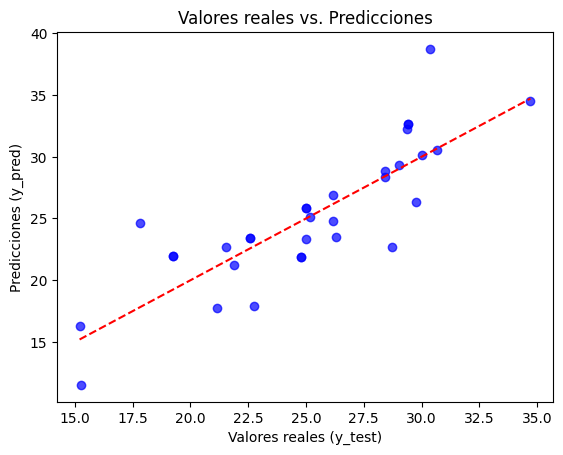

In [203]:
# MODELO DE REGRESIÓN POLINOMICA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Grado del polinomio
degree = 3  

# Crea el pipeline para la regresión polinómica
model = make_pipeline(
    PolynomialFeatures(degree),
    LinearRegression()
)

# Entrenamiento del modelo con los datos de entrenamiento
model.fit(X_train_scaled, y_train)

# Predice en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluacion del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE del modelo en el conjunto de prueba: {mse}")
print(f"R² del modelo en el conjunto de prueba: {r2}")

#VISUALIZACIÓN:
plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Valores reales vs. Predicciones")
plt.show()


In [120]:
player_data_top['game_creation'] = pd.to_datetime(player_data_top['game_creation'])

filtered_data_december = player_data_top[
    (player_data_top['game_creation'] >= '2024-12-01') & 
    (player_data_top['game_creation'] <= '2024-12-31')
]

filtered_data_december['date'] = filtered_data_december['game_creation'].dt.date


filtered_data_december.groupby('summoner_name').nunique()

C:\Users\HP\AppData\Local\Temp\ipykernel_10584\968909274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_december['date'] = filtered_data_december['game_creation'].dt.date


,match_id,data_version,participants,game_creation,game_duration,game_end_timestamp,game_start_timestamp,game_mode,game_version,team_id,...,day_of_week,day_type,day_name,hour_of_day,kda,time_played_minuts,long_game,game_duration_seconds,win_encoded,date
summoner_name,,,,,,,,,,,,,,,,,,,,,
Fleshyy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
IntAcc999,4,1,4,4,4,4,4,1,1,2,...,2,1,2,4,4,4,2,4,2,2
Qiú yú shén,8,1,8,8,8,8,8,1,1,2,...,2,2,2,7,8,8,2,8,2,3
Ruck Fıto,2,1,2,2,2,2,2,1,1,2,...,2,2,2,2,2,2,1,2,2,2
SK Nenrislol,11,1,11,11,11,11,11,1,1,2,...,2,2,2,9,11,11,2,11,2,2
eltuko,10,1,10,10,10,10,10,1,1,2,...,4,2,4,6,10,10,2,10,2,5
itsalreadyjggap,5,1,5,5,5,5,5,1,1,2,...,3,2,3,5,5,5,2,5,2,3
zoed,14,1,14,14,14,14,14,1,1,2,...,5,2,5,9,11,14,2,14,2,5


In [104]:
top_players = player_data_top['summoner_name'].unique()  # Nombres de los 10 mejores jugadores

filtered_data_december = filtered_data_december[
    filtered_data_december['summoner_name'].isin(top_players)
]

# Creacion las características de diciembre
X_december = filtered_data_december[features_columns]

X_december['kda'] = X_december['kda'].fillna(X_december['kda'].mean())


# Escala los datos de diciembre
X_december_scaled = scaler.transform(X_december)


C:\Users\HP\AppData\Local\Temp\ipykernel_10584\1759287023.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_december['kda'] = X_december['kda'].fillna(X_december['kda'].mean())


In [93]:
#predicciones para diciembre
y_pred_december = model.predict(X_december_scaled)

print(y_pred_december[:10])

[15.4        37.7        26.3        18.41666667 37.7        19.06666667
 28.63333333 26.3        15.96666667 19.23333333]


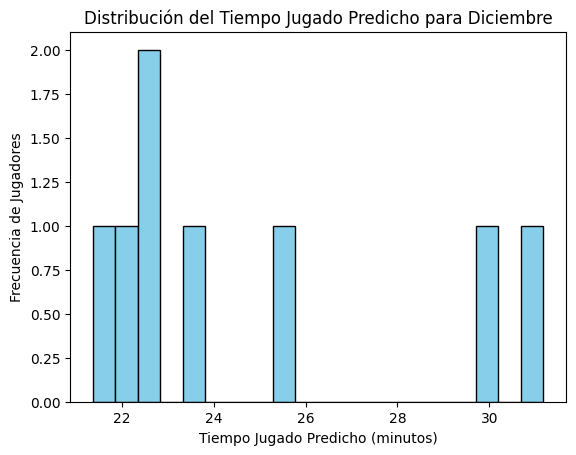

In [115]:
predictions_with_players = filtered_data_december[['summoner_name']].copy()
predictions_with_players['predicted_time'] = y_pred_december

aggregated_predictions = predictions_with_players.groupby('summoner_name')['predicted_time'].mean()

plt.hist(aggregated_predictions, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Tiempo Jugado Predicho (minutos)")
plt.ylabel("Frecuencia de Jugadores")
plt.title("Distribución del Tiempo Jugado Predicho para Diciembre")
plt.show()


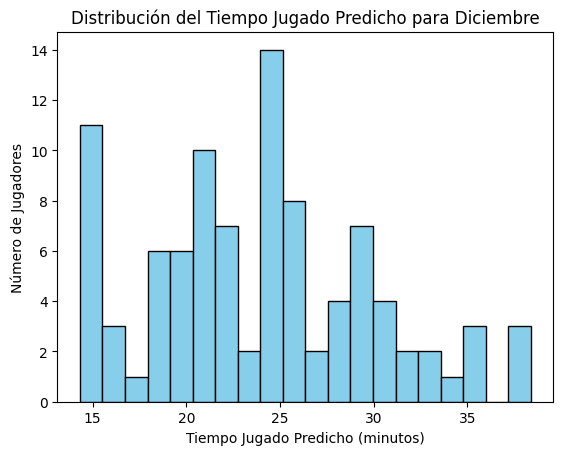

In [95]:
import matplotlib.pyplot as plt

# Grafico la distribución de las predicciones de tiempo jugado en mes diciembre
plt.hist(y_pred_december, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Tiempo Jugado Predicho (minutos)")
plt.ylabel("Frecuencia de Jugadores")
plt.title("Distribución del Tiempo Jugado Predicho para Diciembre")
plt.show()


In [110]:
print(filtered_data_december['summoner_name'].shape)  # Nombres de los jugadores
print(y_pred_december.shape)  # Predicciones


(96,)
(96,)


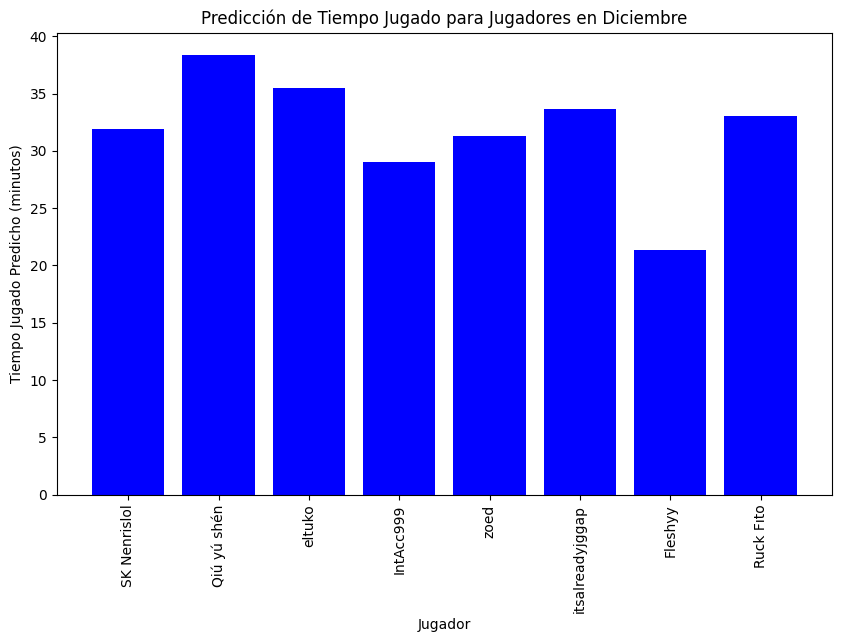

In [282]:
plt.figure(figsize=(10, 6))
plt.bar(filtered_data_december['summoner_name'], y_pred_december, color='blue')
plt.xticks(rotation=90)
plt.xlabel("Jugador")
plt.ylabel("Tiempo Jugado Predicho (minutos)")
plt.title("Predicción de Tiempo Jugado para Jugadores en Diciembre")
plt.show()
